<a href="https://colab.research.google.com/github/pachterlab/CBP_2022/blob/main/notebooks/ContinuousData/ContMCML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import os


from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
	url = 'https://api.datacite.org/dois/'+doi+'/media'
	r = requests.get(url).json()
	netcdf_url = r['data'][0]['attributes']['url']
	r = requests.get(netcdf_url,stream=True)
	#Set file name
	fname = doi.split('/')[-1]+ext
	#Download file with progress bar
	if r.status_code == 403:
		print("File Unavailable")
	if 'content-length' not in r.headers:
		print("Did not get file")
	else:
		with open(fname, 'wb') as f:
			total_length = int(r.headers.get('content-length'))
			pbar = tnrange(int(total_length/1024), unit="B")
			for chunk in r.iter_content(chunk_size=1024):
				if chunk:
					pbar.update()
					f.write(chunk)
		return fname


#Pseudotime Packer & Zhu C. elegans data
#counts.mtx
download_file('10.22002/D1.2060','.gz')

#cells.csv
download_file('10.22002/D1.2061','.gz')

#genes.csv
download_file('10.22002/D1.2062','.gz')


#MERFISH data

#metadata.csv
download_file('10.22002/D1.2063','.gz')

#counts.h5ad
download_file('10.22002/D1.2064','.gz')

os.system("gunzip *.gz")

os.system("mv D1.2063 metadata.csv")
os.system("mv D1.2064 counts.h5ad")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/14905 [00:00<?, ?B/s]

  0%|          | 0/561 [00:00<?, ?B/s]

  0%|          | 0/165 [00:00<?, ?B/s]

  0%|          | 0/9784 [00:00<?, ?B/s]

  0%|          | 0/59360 [00:00<?, ?B/s]

0

In [ ]:
!git clone https://github.com/hhcho/densvis.git

Cloning into 'densvis'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 145 (delta 78), reused 95 (delta 38), pack-reused 0
Receiving objects: 100% (145/145), 412.94 KiB | 2.77 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [ ]:
%cd /content/densvis/densne/

/content/densvis/densne


In [ ]:
!g++ sptree.cpp densne.cpp densne_main.cpp -o den_sne -O2
import densne

densne.cpp: In function ‘bool DENSNE::load_data(double**, int*, int*, int*, double*, double*, int*, int*, double*, double*, bool*, double**)’:
densne.cpp:961:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(n, sizeof(int), 1, h);                                            // number of datapoints
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:962:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(d, sizeof(int), 1, h);                                            // original dimensionality
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:963:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(theta, sizeof(double), 1, h);                                        // gradient accuracy
   ~~~~~^~~~~~~~~~

In [ ]:
%cd /content/

/content


In [ ]:
!git clone https://github.com/pachterlab/CBP_2022.git

Cloning into 'CBP_2021'...
remote: Enumerating objects: 559, done.
remote: Counting objects: 100% (559/559), done.
remote: Compressing objects: 100% (514/514), done.
remote: Total 559 (delta 341), reused 86 (delta 25), pack-reused 0
Receiving objects: 100% (559/559), 82.68 MiB | 17.09 MiB/s, done.
Resolving deltas: 100% (341/341), done.


In [ ]:
%cd /content/CBP_2022/scripts

/content/CBP_2021/scripts


In [ ]:
!pip3 install --quiet torch
!pip3 install --quiet anndata
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn
!pip3 install --quiet torchsummary
!pip install --quiet scanpy==1.6.0
!pip3 install --quiet umap-learn

     |████████████████████████████████| 127 kB 4.1 MB/s 
     |████████████████████████████████| 7.7 MB 4.2 MB/s 
     |████████████████████████████████| 80 kB 8.1 MB/s 
     |████████████████████████████████| 1.1 MB 42.1 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 


## **Install Packages**

In [ ]:
import statistics
import anndata 
import pandas as pd
import numpy as np
from MCML import MCML #Now has continuous label addition

import visualizations as vis
import tools as tl
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis,NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import scale
import torch
import time
import scanpy as sc
import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio
import matplotlib

from sklearn.metrics import accuracy_score

matplotlib.rc('axes',edgecolor='black')
%matplotlib inline

sc.set_figure_params(dpi=125)
sns.set_style('white')

## **Import Data**

In [ ]:
# General parameters
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.1

state = 42
ndims = 2

data_path = '/content'

n_latent = 50
pcs = 50

In [ ]:
def getAllVars(latents,latentLab,latentType):
  emb = []

  vals = []

  dist = []

  dim = []

  allVals = pd.DataFrame()

  for p in range(len(latents)):

    i = latents[p]
    l = latentLab[p]
    d = latentType[p]

    c = tl.getCentroidDists(i, labs[0])
    intra = tl.getIntraVar(i, labs[0], labs[0])


    vals += [stats.pearsonr(c, amb)[0],stats.pearsonr(intra, ambIntra)[0]]
    dist += ['Inter-Type','Intra-Type'] 

    emb += [l]*2
    dim += [d]*2

  allVals['Latent'] = emb
  allVals['Distance'] = dist
  allVals['Pearsonr'] = vals
  allVals['Dimension'] = dim

  return allVals

In [ ]:
def getJac(orig_indices,latents, latentLab, n_neighbors=30):
  emb = []

  xs = []

  ys = []

  knnDF = pd.DataFrame()

  for p in range(len(latents)):
    i = latents[p]
    l = latentLab[p]

    ind = tl.getNeighbors(i, n_neigh = n_neighbors,p=1)

    x = tl.getJaccard(orig_indices,ind)

    xs += x
    #ys += list(y)

    emb += [l]*len(x)

    print(l)

    print(np.mean(tl.getJaccard(orig_indices,ind)))



  knnDF['x'] = xs
  #knnDF['y'] = ys
  knnDF['latent'] = emb

  return knnDF

In [ ]:
#Get fraction of k-nearest neighbors that are the same as in the ambient space
def getAllKNNs(orig_indices,latents,latentLab,latentType):
  emb = []

  frac = []


  knnDF = pd.DataFrame()

  for p in range(len(latents)):
    i = latents[p]
    l = latentLab[p]

    ind = tl.getNeighbors(i, n_neigh = 10,p=1)

    frac += [np.mean(tl.getIntersect(orig_indices,ind))]



    emb += [l]


  knnDF['Fraction'] = frac
  knnDF['Latent'] = emb

  return knnDF

In [ ]:
def knn_infer(embd_space, labeled_idx, labeled_lab, unlabeled_idx,n_neighbors=50):
	"""
	Predicts the labels of unlabeled data in the embedded space with KNN.
	Parameters
	----------
	embd_space : ndarray (n_samples, embedding_dim)
		Each sample is described by the features in the embedded space.
		Contains all samples, both labeled and unlabeled.
	labeled_idx : list
		Indices of the labeled samples (used for training the classifier).
	labeled_lab : ndarray (n_labeled_samples)
		Labels of the labeled samples.
	unlabeled_idx : list
		Indices of the unlabeled samples.
	Returns
	-------
	pred_lab : ndarray (n_unlabeled_samples)
		Inferred labels of the unlabeled samples.
	"""

	# obtain labeled data and unlabled data from indices
	labeled_samp = embd_space[labeled_idx, :]
	unlabeled_samp = embd_space[unlabeled_idx, :]

	from sklearn.neighbors import KNeighborsClassifier

	knn = KNeighborsClassifier(n_neighbors=n_neighbors)
	knn.fit(labeled_samp, labeled_lab)

	pred_lab = knn.predict(unlabeled_samp)
	return pred_lab


In [ ]:
from sklearn.metrics import plot_confusion_matrix
def conf_matrix(embd_space, labeled_idx, labeled_lab, unlabeled_idx,unlabeled_lab,n_neighbors=50,axisFontSize=11,tickFontSize=8,fname=None ):
  """
  Predicts the labels of unlabeled data in the embedded space with KNN and plots confusion matrix.
  Parameters
  ----------
  embd_space : ndarray (n_samples, embedding_dim)
    Each sample is described by the features in the embedded space.
    Contains all samples, both labeled and unlabeled.
  labeled_idx : list
    Indices of the labeled samples (used for training the classifier).
  labeled_lab : ndarray (n_labeled_samples)
    Labels of the labeled samples.
  unlabeled_idx : list
    Indices of the unlabeled samples.
  Returns
  -------
  pred_lab : ndarray (n_unlabeled_samples)
    Inferred labels of the unlabeled samples.
  """

  # obtain labeled data and unlabled data from indices
  labeled_samp = embd_space[labeled_idx, :]
  unlabeled_samp = embd_space[unlabeled_idx, :]

  from sklearn.neighbors import KNeighborsClassifier

  knn = KNeighborsClassifier(n_neighbors=n_neighbors)
  knn.fit(labeled_samp, labeled_lab)
  
  matrix = plot_confusion_matrix(knn, unlabeled_samp, unlabeled_lab,
                          cmap=plt.cm.Purples,
                          normalize='true',xticks_rotation='vertical',include_values=False)

  plt.xlabel('True Cell Type',fontsize=axisFontSize)

  plt.ylabel('Predicted Cell Type',fontsize=axisFontSize)
  plt.xticks(fontsize=tickFontSize)
  plt.yticks(fontsize=tickFontSize)

 
  plt.title('Confusion Matrix',fontsize=axisFontSize)
  
  if(fname != None):
    plt.savefig(fname)
  else:
    plt.show(matrix)
    plt.show()
  
  

	#pred_lab = knn.predict(unlabeled_samp)


In [ ]:

def knnReg_infer(embd_space, labeled_idx, labeled_lab, unlabeled_idx,n_neighbors=10):
	"""
	Predicts the labels of unlabeled data in the embedded space with KNN.
	Parameters
	----------
	embd_space : ndarray (n_samples, embedding_dim)
		Each sample is described by the features in the embedded space.
		Contains all samples, both labeled and unlabeled.
	labeled_idx : list
		Indices of the labeled samples (used for training the classifier).
	labeled_lab : ndarray (n_labeled_samples)
		Labels of the labeled samples.
	unlabeled_idx : list
		Indices of the unlabeled samples.
	Returns
	-------
	pred_lab : ndarray (n_unlabeled_samples)
		Inferred labels (continuous) of the unlabeled samples.
	"""

	# obtain labeled data and unlabled data from indices
	labeled_samp = embd_space[labeled_idx, :]
	unlabeled_samp = embd_space[unlabeled_idx, :]

	knn = KNeighborsRegressor(n_neighbors=n_neighbors,weights='distance')
	knn.fit(labeled_samp, labeled_lab)

	pred_lab = knn.predict(unlabeled_samp)
	return pred_lab

In [ ]:
def reconComp(scaled_mat, ndims=2, pcs=50, rounds = 3):
  """ Compute latent space representations as baseline for reconstruction abilities
	scaled_mat : Numpy array of latent space (n_obs x n_latent)
	ndims : No. of dimensions to reduce scaled_mat to
	pcs : No. of PCs to use
	rounds : No. of rounds to replicate over
	Returns:
	latents : List containing each generated latent space
	latentLab : List containing label for each latent space
	latentType : List containing broad category label for each latent space
  """

  latents = []
  latentLab = []
  latentType = []

  nanLabs = np.array([[np.nan]*scaled_mat.shape[0]])

  for i in range(rounds):
   
    reducer = umap.UMAP(n_components = 2)
    tsne = TSNE(n_components = 2) 

    tsvd = TruncatedSVD(n_components=pcs)
    x_pca = tsvd.fit_transform(scaled_mat)

    pcaUMAP = reducer.fit_transform(x_pca)
    pcaTSNE = tsne.fit_transform(x_pca)


		#MCML runs
    ncaR = MCML(n_latent = pcs, epochs = 100)

    lossesR, latentR = ncaR.fit(scaled_mat,nanLabs,fracNCA = 0, silent = True,ret_loss = True)

    latents += [latentR, x_pca, pcaUMAP, pcaTSNE]
    latentLab += ['Recon MCML 50D','PCA 50D','PCA t-SNE','PCA UMAP']
    latentType += ['50D','50D','2D','2D']

  return latents,latentLab,latentType

## **Packer & Zhu et al *C. elegans* Data (Pseudotime Labels)**

Read in data

In [ ]:
!mv {data_path}/D1.2060 {data_path}/counts.mtx
!mv {data_path}/D1.2061 {data_path}/cells.csv
!mv {data_path}/D1.2062 {data_path}/genes.csv


In [ ]:
pseudo = sc.read(data_path+'/counts.mtx', cache=True).T
print(pseudo)

geneMeta = pd.read_csv(data_path+'/genes.csv')
print(geneMeta.head())
cellMeta = pd.read_csv(data_path+'/cells.csv')
print(cellMeta.head())

AnnData object with n_obs × n_vars = 6188 × 20222
               id gene_short_name  num_cells_expressed
0  WBGene00010957          nduo-6                 6038
1  WBGene00010958          ndfl-4                 1597
2  WBGene00010959          nduo-1                 5342
3  WBGene00010960           atp-6                 5921
4  WBGene00010961          nduo-2                 2686
                       cell  n.umi  ... bg.b01.loading bg.b02.loading
0  AAACCTGCAAGACGTG-300.1.1   1003  ...      -2.284804      -2.130261
1  AAACCTGGTGTGAATA-300.1.1   1458  ...       1.640686       0.153481
2  AAACCTGTCGGCCGAT-300.1.1   1633  ...      -0.137057      -0.518981
3  AAAGATGGTTCGTTGA-300.1.1   1716  ...      -0.961214      -2.266003
4  AACCATGAGAAACCTA-300.1.1   1799  ...      -2.935370      -2.613732

[5 rows x 19 columns]


In [ ]:
pseudo.obs_names = cellMeta.cell
pseudo.var_names = geneMeta.id
pseudo.obs['type'] = pd.Categorical(cellMeta['cell.type'])
pseudo

AnnData object with n_obs × n_vars = 6188 × 20222
    obs: 'type'

Generate pseudotime values for cells in neural lineage

In [ ]:
#Subset for ASE_ASJ_AUA lineage
pseudo_sub = pseudo[pseudo.obs['type'].isin(['ASJ','AUA','ASE_parent','Neuroblast_ASJ_AUA','ASE','ASEL','ASER','Neuroblast_ASE_ASJ_AUA'])] #'ASI_parent','ASI','ASK_parent'

sc.pp.filter_cells(pseudo_sub, min_counts=0)
sc.pp.filter_genes(pseudo_sub, min_counts=0)

pseudo_copy = pseudo_sub.copy()
sc.pp.normalize_per_cell(pseudo_copy, counts_per_cell_after=1e4)
raw = pseudo_copy.X

sc.pp.log1p(pseudo_copy)
pseudo_copy.obsm['log'] = pseudo_copy.X

sc.pp.highly_variable_genes(pseudo_copy,n_top_genes=300)

pseudo_copy = pseudo_copy[:,pseudo_copy.var['highly_variable']]

#Center scale
sc.pp.scale(pseudo_copy, max_value=10)
sc.tl.pca(pseudo_copy, n_comps=50)
sc.pp.neighbors(pseudo_copy,n_neighbors=50, n_pcs=15,method='gauss')

pseudo_copy.uns['iroot'] = np.flatnonzero(pseudo_copy.obs['type']  == 'Neuroblast_ASE_ASJ_AUA')[0]

sc.tl.diffmap(pseudo_copy,n_comps=10)
sc.tl.dpt(pseudo_copy,n_dcs=10) #Creates 'dpt_pseudotime'

pseudo_copy

Trying to set attribute `.obs` of view, copying.
/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 1075 × 299
    obs: 'type', 'n_counts', 'dpt_pseudotime'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'iroot', 'diffmap_evals'
    obsm: 'log', 'X_pca', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
count_mat = pseudo_copy.X

In [ ]:
#Set colors for cell clusters
colors = np.random.rand(len(pseudo_copy.obs['type']),3)
nanLabs = np.array([[np.nan]*len(pseudo_copy.obs['type'])])

labs = np.array([list(pseudo_copy.obs['type'])])
labs_cont = np.array([list(pseudo_copy.obs['dpt_pseudotime'])])

### **Compare KNN Attributes and Prediction for Partially Labeled Data**

In [ ]:
rounds = 3

In [ ]:
d = np.array(pseudo_copy.obsm['log'].todense())

Get inter- and intra-distances in ambient space

In [ ]:
amb = tl.getCentroidDists(d,labs[0])
ambIntra = tl.getIntraVar(d, labs[0],labs[0])


In [ ]:
def compAll(scaled_mat, ndims=2, pcs=50, rounds = 3):
	""" Compute latent space representations usually used for visualization"""
	latents = []
	latentLab = []
	latentType = []

	nanLabs = np.array([[np.nan]*scaled_mat.shape[0]])

	for i in range(rounds):
		reducer = umap.UMAP(n_components = ndims) # random_state = state
		tsne = TSNE(n_components = ndims) 

		tsvd = TruncatedSVD(n_components=pcs)
		x_pca = tsvd.fit_transform(scaled_mat)

		tsvd = TruncatedSVD(n_components=2)
		x_pca_2d = tsvd.fit_transform(scaled_mat)

		pcaUMAP = reducer.fit_transform(x_pca)

		pcaTSNE = tsne.fit_transform(x_pca)


		#MCML runs
		ncaR = MCML(n_latent = pcs, epochs = 100)

		lossesR, latentR = ncaR.fit(scaled_mat,nanLabs,fracNCA = 0, silent = True,ret_loss = True)

		latentRUMAP = reducer.fit_transform(latentR)

		latentRTSNE = tsne.fit_transform(latentR)


		latents += [latentR, x_pca, x_pca_2d, latentRTSNE, pcaTSNE, latentRUMAP, pcaUMAP]
		latentLab += ['Recon MCML 50D','PCA 50D','PCA 2D','Recon MCML TSNE','PCA TSNE','Recon MCML UMAP','PCA UMAP']
		latentType += ['50D','50D','2D','2D','2D','2D','2D']

	return latents,latentLab,latentType

#### **KNN Comparisons to Original Coordinate Data**

Label 20% of cells

In [ ]:
#80% labeled
rounds = 1
unlab = []
unlabLab = []
unlabType = []
for i in range(rounds):
  numLabs = int(np.round(len(nanLabs[0])*0.8))
  allPos = range(len(nanLabs[0]))
  labeled_idx = random.sample(allPos,numLabs)
  unlabeled_idx = [i for i in allPos if i not in labeled_idx]


  labeled_lab = labs_cont.T[labeled_idx ,:]

  unlabeled_lab = labs_cont.T[unlabeled_idx ,:]

  newLabs = labs_cont.copy().T

  newLabs[unlabeled_idx,:] = np.nan

  ncaMiss = MCML(n_latent = n_latent, epochs = 1000) #n_latent

  tic = time.perf_counter()
  lossesNCAMiss, latentNCAMiss = ncaMiss.fit(count_mat,nanLabs, newLabs.T,dim_cont = [1],fracNCA = 0.9999, silent = True,ret_loss = True)
  toc = time.perf_counter()
  print(f"nnNCA fit in {toc - tic:0.4f} seconds")

  unlab += [latentNCAMiss]
  unlabLab += ['NCA 20% Unlabeled MCML 50D']
  unlabType += ['MCML 50D']


nnNCA fit in 255.2328 seconds


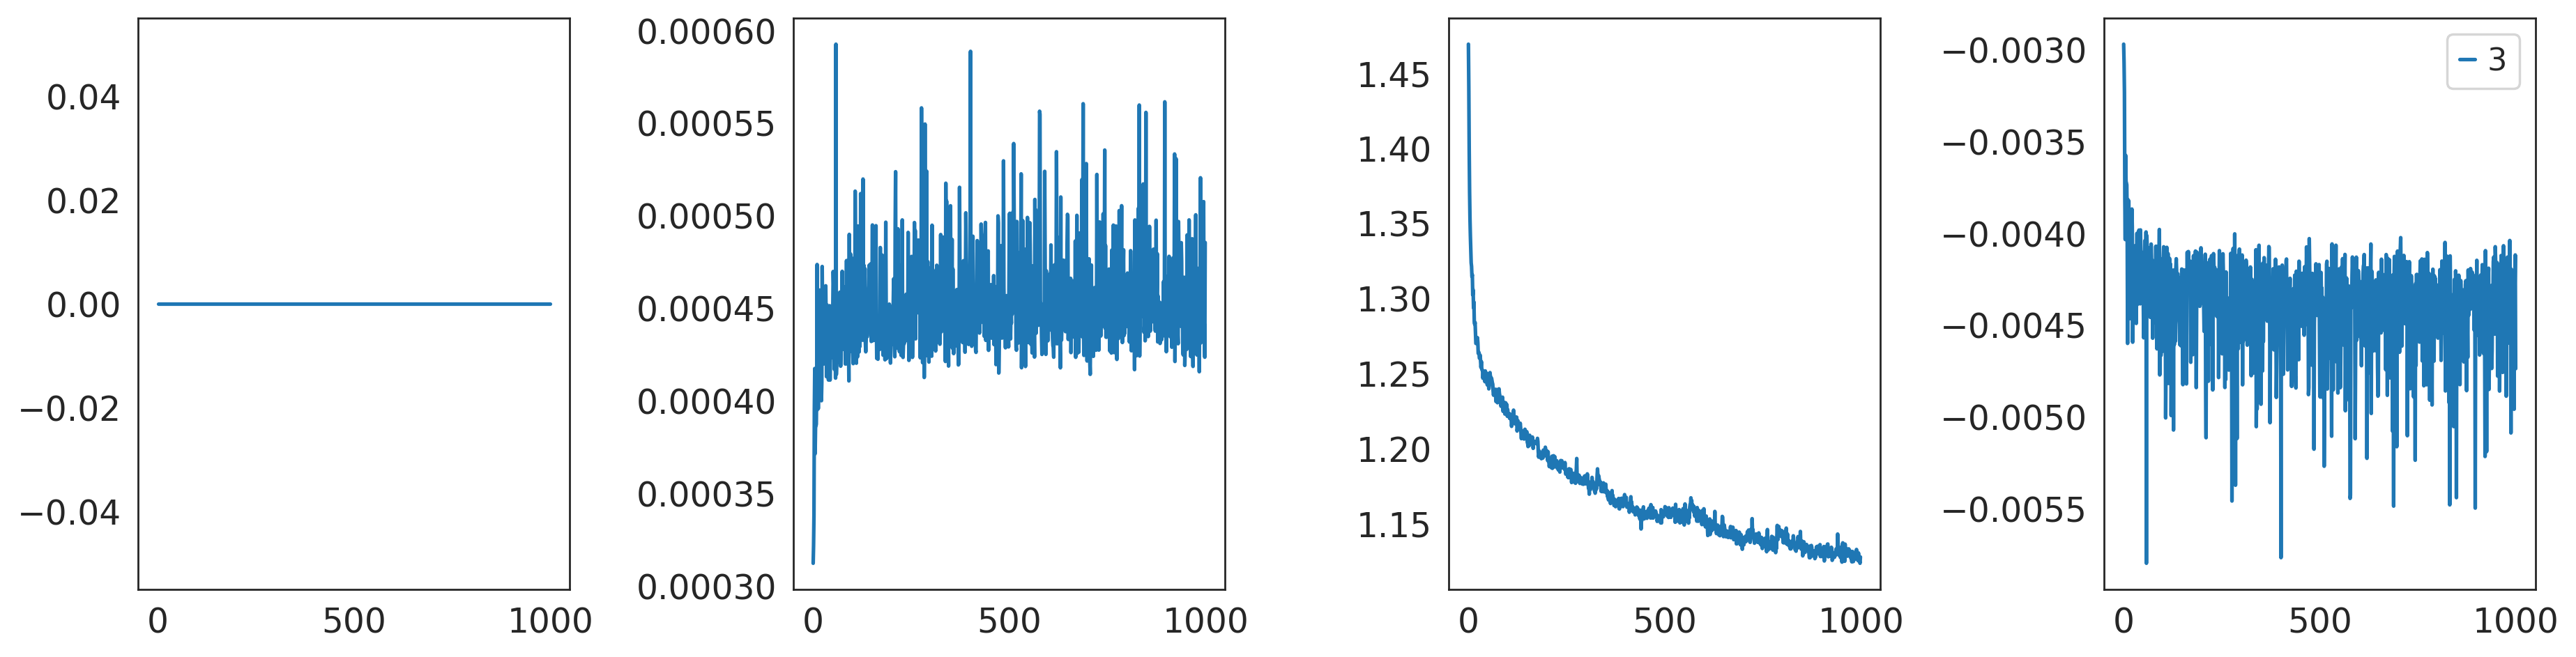

In [ ]:
fig, axs = plt.subplots(1, lossesNCAMiss.shape[1],figsize=(15,4))
for i in range(lossesNCAMiss.shape[1]):
  axs[i].plot(lossesNCAMiss[:,i],label=str(i))
  
plt.legend()
plt.tight_layout()
plt.show()

Get other latent spaces for comparison

In [ ]:
latents,latentLab,latentType = compAll(count_mat, ndims=2, pcs=50)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Get neighbors in original/ambient space

In [ ]:
orig_indices = tl.getNeighbors(labs_cont.T, n_neigh = 50,p=2)

In [ ]:
latents = unlab + latents #[1:]

latentLab = unlabLab + latentLab #[1:]

latentType = unlabType + latentType #[1:]

In [ ]:


emb = []

xs = []

ys = []

knnDF = pd.DataFrame()

for p in range(len(latents)):
  i = latents[p]
  l = latentLab[p]

  ind = tl.getNeighbors(i, n_neigh = 50,p=2)

  x,y = tl.ecdf(tl.getJaccard(orig_indices,ind))

  xs += list(x)
  ys += list(y)

  emb += [l]*len(x)


  print(l)
  print(statistics.mode(tl.getJaccard(orig_indices,ind)))
  print(np.mean(tl.getJaccard(orig_indices,ind)))



knnDF['x'] = xs
knnDF['y'] = ys
knnDF['latent'] = emb



NCA 20% Unlabeled MCML 50D
0.7012987012987013
0.6705130474539778
Recon MCML 50D
0.9247311827956989
0.8819455176131666
PCA 50D
0.9130434782608696
0.8801662297949614
PCA 2D
0.9361702127659575
0.8490945649626709
Recon MCML TSNE
0.9473684210526316
0.8460722578025639
PCA TSNE
0.9130434782608696
0.8440272541955024
Recon MCML UMAP
0.9361702127659575
0.8344676977989546
PCA UMAP
0.9473684210526316
0.8321993903959966
Recon MCML 50D
0.9130434782608696
0.8818248369652546
PCA 50D
0.9247311827956989
0.8800204309957247
PCA 2D
0.9361702127659575
0.8490843650442702
Recon MCML TSNE
0.9473684210526316
0.8449424722170331
PCA TSNE
0.9130434782608696
0.8440456487252295
Recon MCML UMAP
0.9361702127659575
0.832060073115378
PCA UMAP
0.9473684210526316
0.8333082765822075
Recon MCML 50D
0.9130434782608696
0.8821301078618229
PCA 50D
0.9247311827956989
0.8800730196874003
PCA 2D
0.9361702127659575
0.8490943254183289
Recon MCML TSNE
0.9361702127659575
0.8511018563705128
PCA TSNE
0.9247311827956989
0.8467176596557037

In [ ]:
knnDF['latent'] = [i.replace('NCA 20% Unlabeled MCML 50D','Pseudotime MCML 50D') for i in knnDF['latent']]

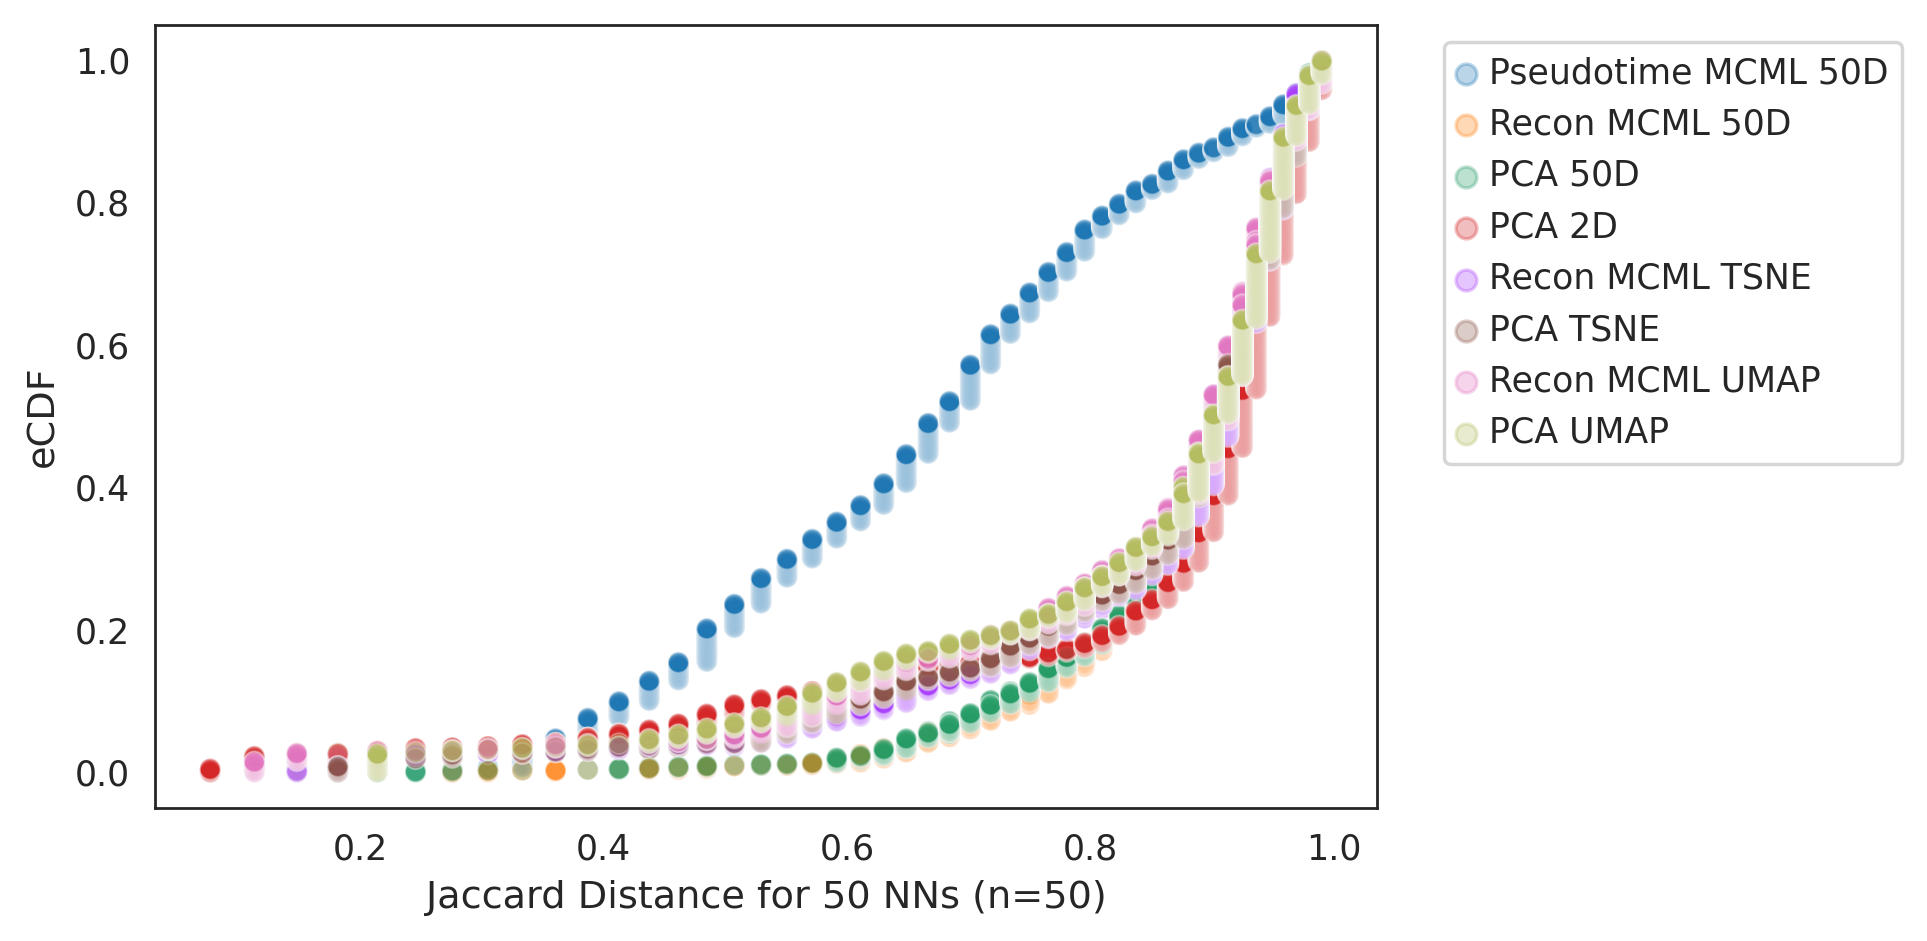

In [ ]:
#80% labeled data
plt.figure(figsize=(8,4))
g=sns.scatterplot(data=knnDF, x='x', y='y', hue='latent',
                  palette={"Pseudotime MCML 50D":sns.color_palette()[0],"Recon MCML 50D":sns.color_palette()[1],
                  "PCA 50D":sns.color_palette()[2],"PCA 2D":sns.color_palette()[3],"Recon MCML TSNE":sns.color_palette()[4],"PCA TSNE":sns.color_palette()[5],
                  "Recon MCML UMAP":sns.color_palette()[6],"PCA UMAP":sns.color_palette()[7]})
plt.setp(g.collections, alpha=.3) #for the markers
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})

plt.xlabel("Jaccard Distance for 50 NNs (n=50)",fontsize=11)
plt.ylabel("eCDF",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

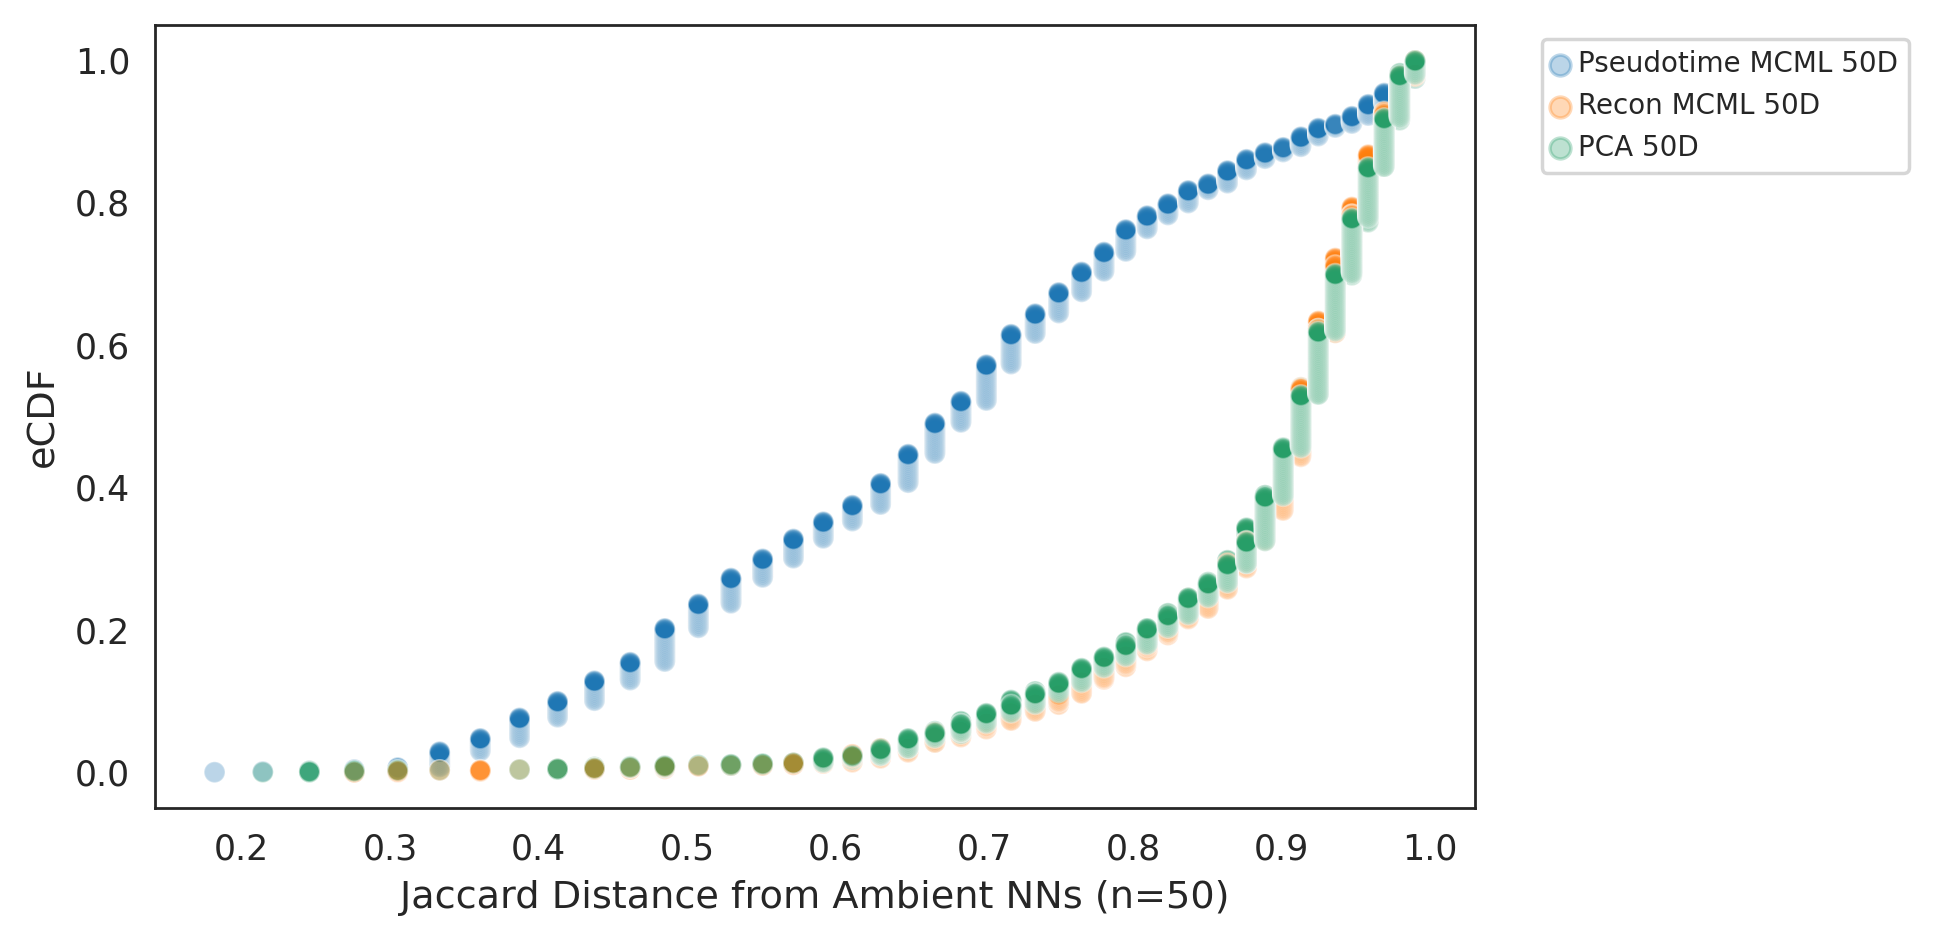

In [ ]:

sub = knnDF[~knnDF['latent'].isin(['Recon MCML TSNE','PCA TSNE','Recon MCML UMAP','PCA UMAP','PCA 2D'])]
#80% labeled data
plt.figure(figsize=(8,4))
g=sns.scatterplot(data=sub, x='x', y='y', hue='latent',
                  palette={"Pseudotime MCML 50D":sns.color_palette()[0],"Recon MCML 50D":sns.color_palette()[1],
                  "PCA 50D":sns.color_palette()[2],"PCA 2D":sns.color_palette()[3],"Recon MCML TSNE":sns.color_palette()[4],"PCA TSNE":sns.color_palette()[5],
                  "Recon MCML UMAP":sns.color_palette()[6],"PCA UMAP":sns.color_palette()[7]})
plt.setp(g.collections, alpha=.3) #for the markers

current_handles, current_labels = plt.gca().get_legend_handles_labels()

plt.legend(current_handles,['Pseudotime MCML 50D',
                            'Recon MCML 50D','PCA 50D'],
           bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":8})

plt.xlabel("Jaccard Distance from Ambient NNs (n=50)",fontsize=11)
plt.ylabel("eCDF",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

Test Position Prediction

In [ ]:
emb = []

xs = []

ys = []

knnDF = pd.DataFrame()

for p in range(len(latents)):
  i = latents[p]
  l = latentLab[p]

  preds = tl.knnReg_infer(i, labeled_idx, labeled_lab, unlabeled_idx,n_neighbors=50) 
  #x,y = tl.ecdf(np.linalg.norm(preds -  unlabeled_lab,axis=1)) #Get distance from actual values
  x = np.linalg.norm(preds -  unlabeled_lab,axis=1)



  #print(str(l)+' MSE: '+str(mean_squared_error(unlabeled_lab,preds)))

  xs += list(x)
  #ys += list(y)

  emb += [l]*len(x)


knnDF['x'] = xs
#knnDF['y'] = ys
knnDF['latent'] = emb



Get avg distance between pseudotime values of 50 NNs and all cells (all pairwise distances)

In [ ]:
avg = 0
for i in range(len(orig_indices)):
  d = pairwise_distances(labs_cont.T[orig_indices[i][1:],:])
  avg += np.mean(d[d!=0])

avg = avg/len(orig_indices)

In [ ]:
allD = pairwise_distances(labs_cont.T)
avgAll = np.mean(allD[allD!=0])

In [ ]:
sub = knnDF[~knnDF['latent'].isin(['Recon MCML TSNE','PCA TSNE','Recon MCML UMAP','PCA UMAP','PCA 2D'])]


In [ ]:
knnDF['latent'] = [i.replace('NCA 20% Unlabeled MCML 50D','Pseudotime MCML 50D') for i in knnDF['latent']]

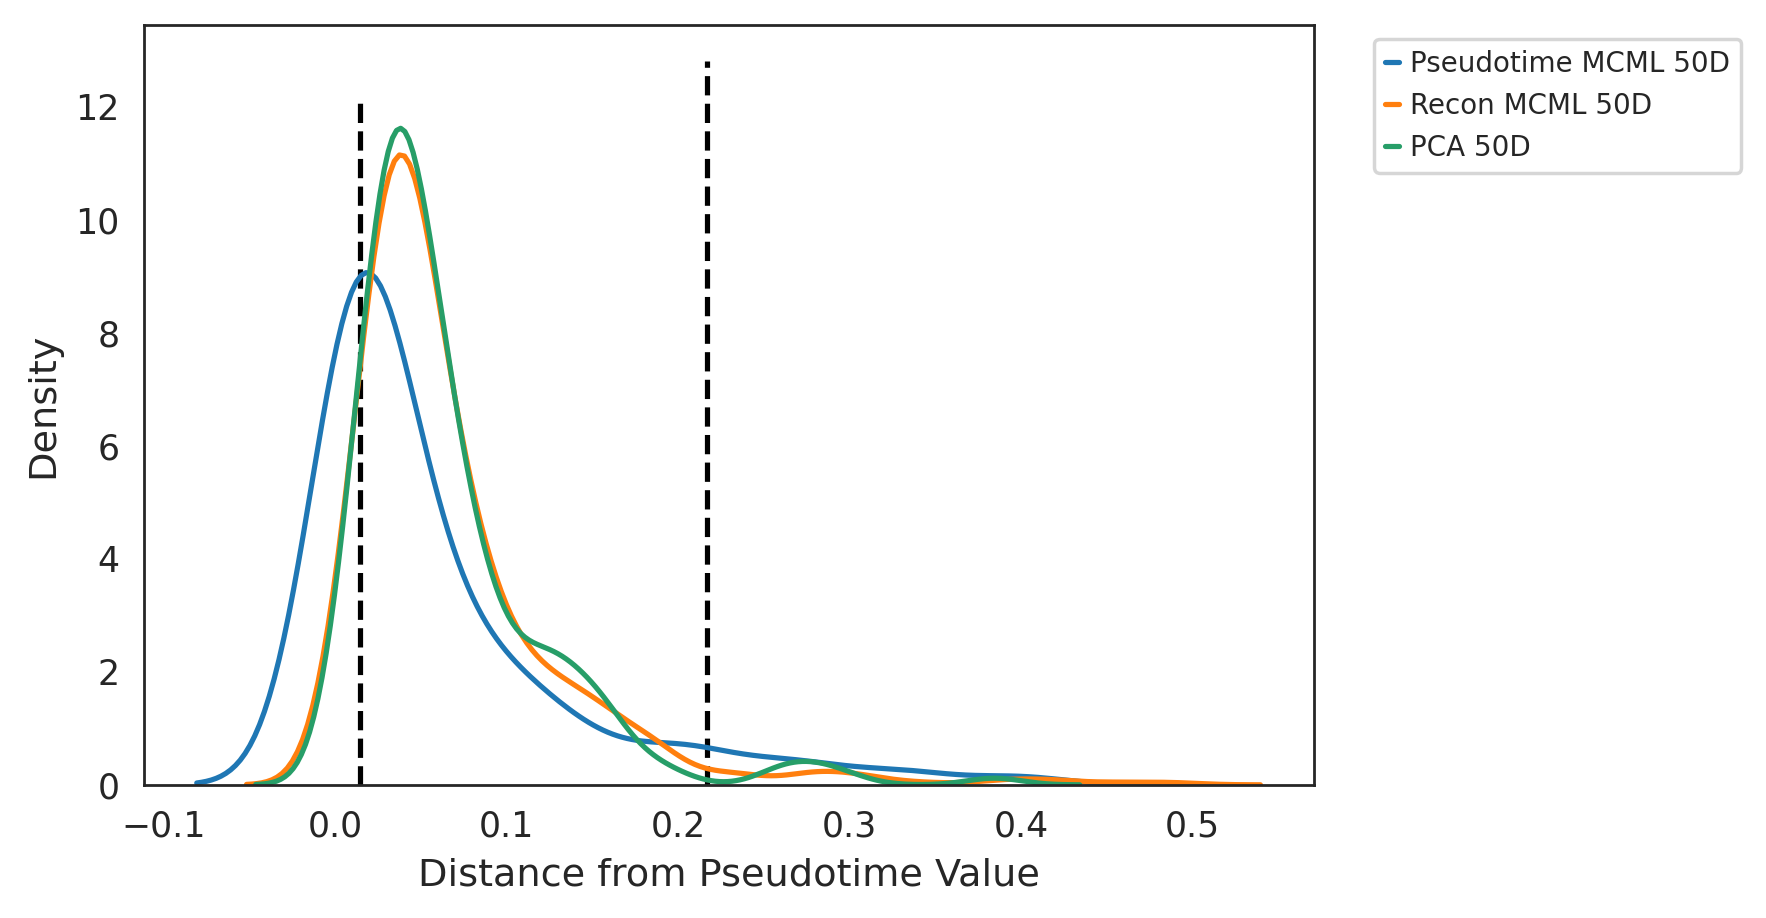

In [ ]:
from matplotlib.ticker import FormatStrFormatter

palette={"Pseudotime MCML 50D":sns.color_palette()[0],"Recon MCML 50D":sns.color_palette()[1],
                  "PCA 50D":sns.color_palette()[2],"PCA 2D":sns.color_palette()[3],"Recon MCML TSNE":sns.color_palette()[4],"PCA TSNE":sns.color_palette()[5],
                  "Recon MCML UMAP":sns.color_palette()[6],"PCA UMAP":sns.color_palette()[7],
                  "Type NCA 20% Unlabeled MCML 50D":sns.color_palette()[8],"Dual NCA 20% Unlabeled MCML 50D":sns.color_palette()[15]}


plt.figure(figsize=(6,4))

sns.kdeplot(sub.x[sub.latent.isin(["NCA 20% Unlabeled MCML 50D"])],color=sns.color_palette()[0],label='Pseudotime MCML 50D')
sns.kdeplot(sub.x[sub.latent.isin(["Recon MCML 50D"])],color=sns.color_palette()[1],label='Recon MCML 50D')
g=sns.kdeplot(sub.x[sub.latent.isin(["PCA 50D"])],color=sns.color_palette()[2],label='PCA 50D')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":8})



plt.xlabel("Distance from Pseudotime Value",fontsize=11)

plt.ylabel("Density",fontsize=11)



plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

#g.xaxis.set_major_formatter(FormatStrFormatter('%.6f'))

plt.vlines([avg],g.get_ylim()[0],g.get_ylim()[1], linestyles='dashed', colors='black') #mean distances between cells
plt.vlines([avgAll],g.get_ylim()[0],g.get_ylim()[1], linestyles='dashed', colors='black') #mean distances between cells

plt.show()

In [ ]:
min(sub.x)

0.00016035199165342906

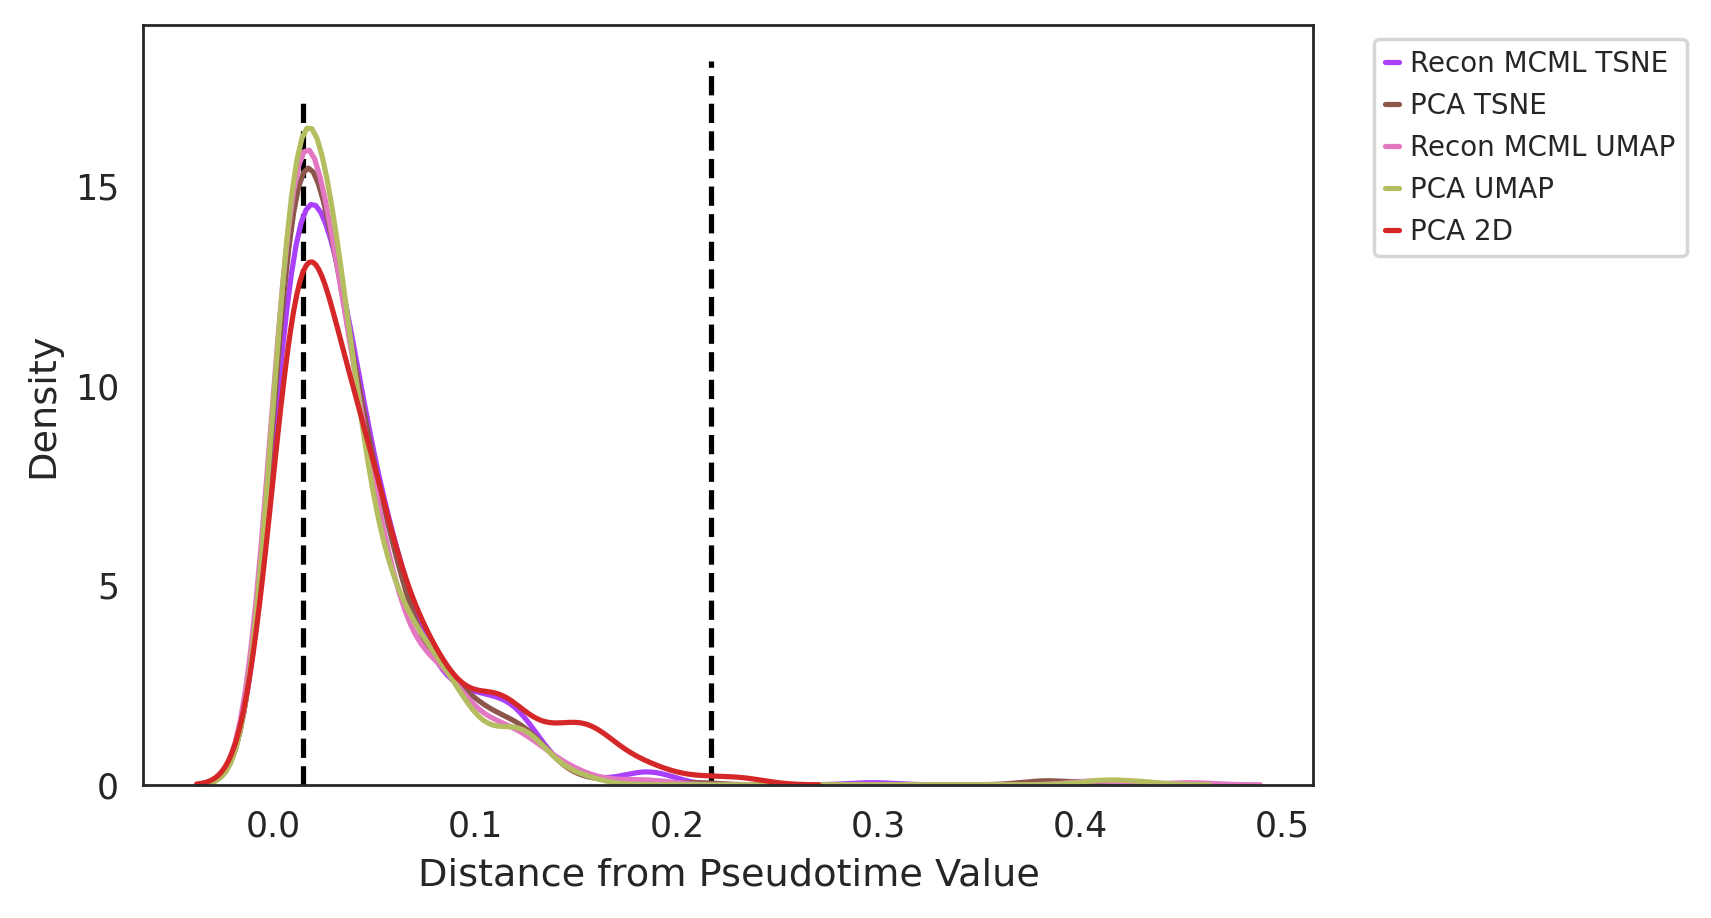

In [ ]:
sub = knnDF[knnDF['latent'].isin(['Recon MCML TSNE','PCA TSNE','Recon MCML UMAP','PCA UMAP','PCA 2D'])]


plt.figure(figsize=(6,4))
sns.kdeplot(sub.x[sub.latent.isin(["Recon MCML TSNE"])],color=sns.color_palette()[4],label='Recon MCML TSNE')
sns.kdeplot(sub.x[sub.latent.isin(["PCA TSNE"])],color=sns.color_palette()[5],label='PCA TSNE')
sns.kdeplot(sub.x[sub.latent.isin(["Recon MCML UMAP"])],color=sns.color_palette()[6],label='Recon MCML UMAP')
sns.kdeplot(sub.x[sub.latent.isin(["PCA UMAP"])],color=sns.color_palette()[7],label='PCA UMAP')
g=sns.kdeplot(sub.x[sub.latent.isin(["PCA 2D"])],color=sns.color_palette()[3],label='PCA 2D')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":8})



plt.xlabel("Distance from Pseudotime Value",fontsize=11)

plt.ylabel("Density",fontsize=11)


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

#g.xaxis.set_major_formatter(FormatStrFormatter('%.6f'))

plt.vlines([avg],g.get_ylim()[0],g.get_ylim()[1], linestyles='dashed', colors='black') #mean distances between cells
plt.vlines([avgAll],g.get_ylim()[0],g.get_ylim()[1], linestyles='dashed', colors='black') #mean distances between cells

plt.show()

## **Merfish Data**

In [ ]:
counts = anndata.read(data_path+'/counts.h5ad')
print(counts)

cellMeta = pd.read_csv(data_path+'/metadata.csv')
print(cellMeta.head())

AnnData object with n_obs × n_vars = 280327 × 254
     Unnamed: 0  fovID     fov_x  ...     label     subclass    class_label
0  1.000010e+37     13  4539.310  ...   Astro_1   Astrocytes          Other
1  1.000020e+38    290 -4016.860  ...      Endo  Endothelial          Other
2  1.000070e+38    113   750.406  ...       SMC          SMC          Other
3  1.000070e+38    432  1262.680  ...      Endo  Endothelial          Other
4  1.000090e+38    354 -3627.450  ...  L23_IT_3       L23_IT  Glutamatergic

[5 rows x 12 columns]


In [ ]:
axisFontSize = 11
tickFontSize = 10
errwidth=1
figsize =(8,4)
dodge=0.4

In [ ]:
cellMeta.columns

Index(['Unnamed: 0', 'fovID', 'fov_x', 'fov_y', 'volume', 'center_x',
       'center_y', 'slice_id', 'sample_id', 'label', 'subclass',
       'class_label'],
      dtype='object')

In [ ]:
choice = np.unique(cellMeta.slice_id)[7] #7
choice

'mouse1_slice162'

In [ ]:
counts.obs['slice'] = pd.Categorical(cellMeta.slice_id)
counts.obs['type'] = pd.Categorical(cellMeta.subclass)
counts.obs['x'] = list(cellMeta.center_x)
counts.obs['y'] = list(cellMeta.center_y)


In [ ]:
sub = counts[counts.obs['slice'].isin([choice])]
print(sub)

colors = np.random.rand(len(sub.obs['type']),3)
nanLabs = np.array([[np.nan]*len(sub.obs['type'])])

labs = np.array([list(sub.obs['type'])])
labs_cont = np.array([list(sub.obs['x']),list(sub.obs['y'])])

View of AnnData object with n_obs × n_vars = 6963 × 254
    obs: 'slice', 'type', 'x', 'y'


In [ ]:
sub.obs['type'].value_counts()

L45_IT              977
L23_IT              946
L6_CT               582
Astrocytes          546
Oligodendrocytes    522
Endothelial         505
L5_IT               441
L6_IT               439
other               204
Pericytes           195
L5_PT               185
Microglia           182
Pvalb               167
PVM                 164
VLMC                139
OPC                 131
L6_IT_Car3          123
SMC                 119
L6b                 104
Sst                  92
L56_NP               78
Lamp5                59
Vip                  53
Sncg                  5
Sst_Chodl             5
Name: type, dtype: int64

Make log-normalized, and scaled count matrices (separately)

In [ ]:
orig_mat = sub.X

In [ ]:
log_mat = np.log1p(sub.X)

In [ ]:
sc.pp.log1p(sub)

#Center scale
sc.pp.scale(sub, max_value=10)

scaled_mat = sub.X

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
amb = tl.getCentroidDists(log_mat,labs[0])
ambIntra = tl.getIntraVar(log_mat, labs[0],labs[0])

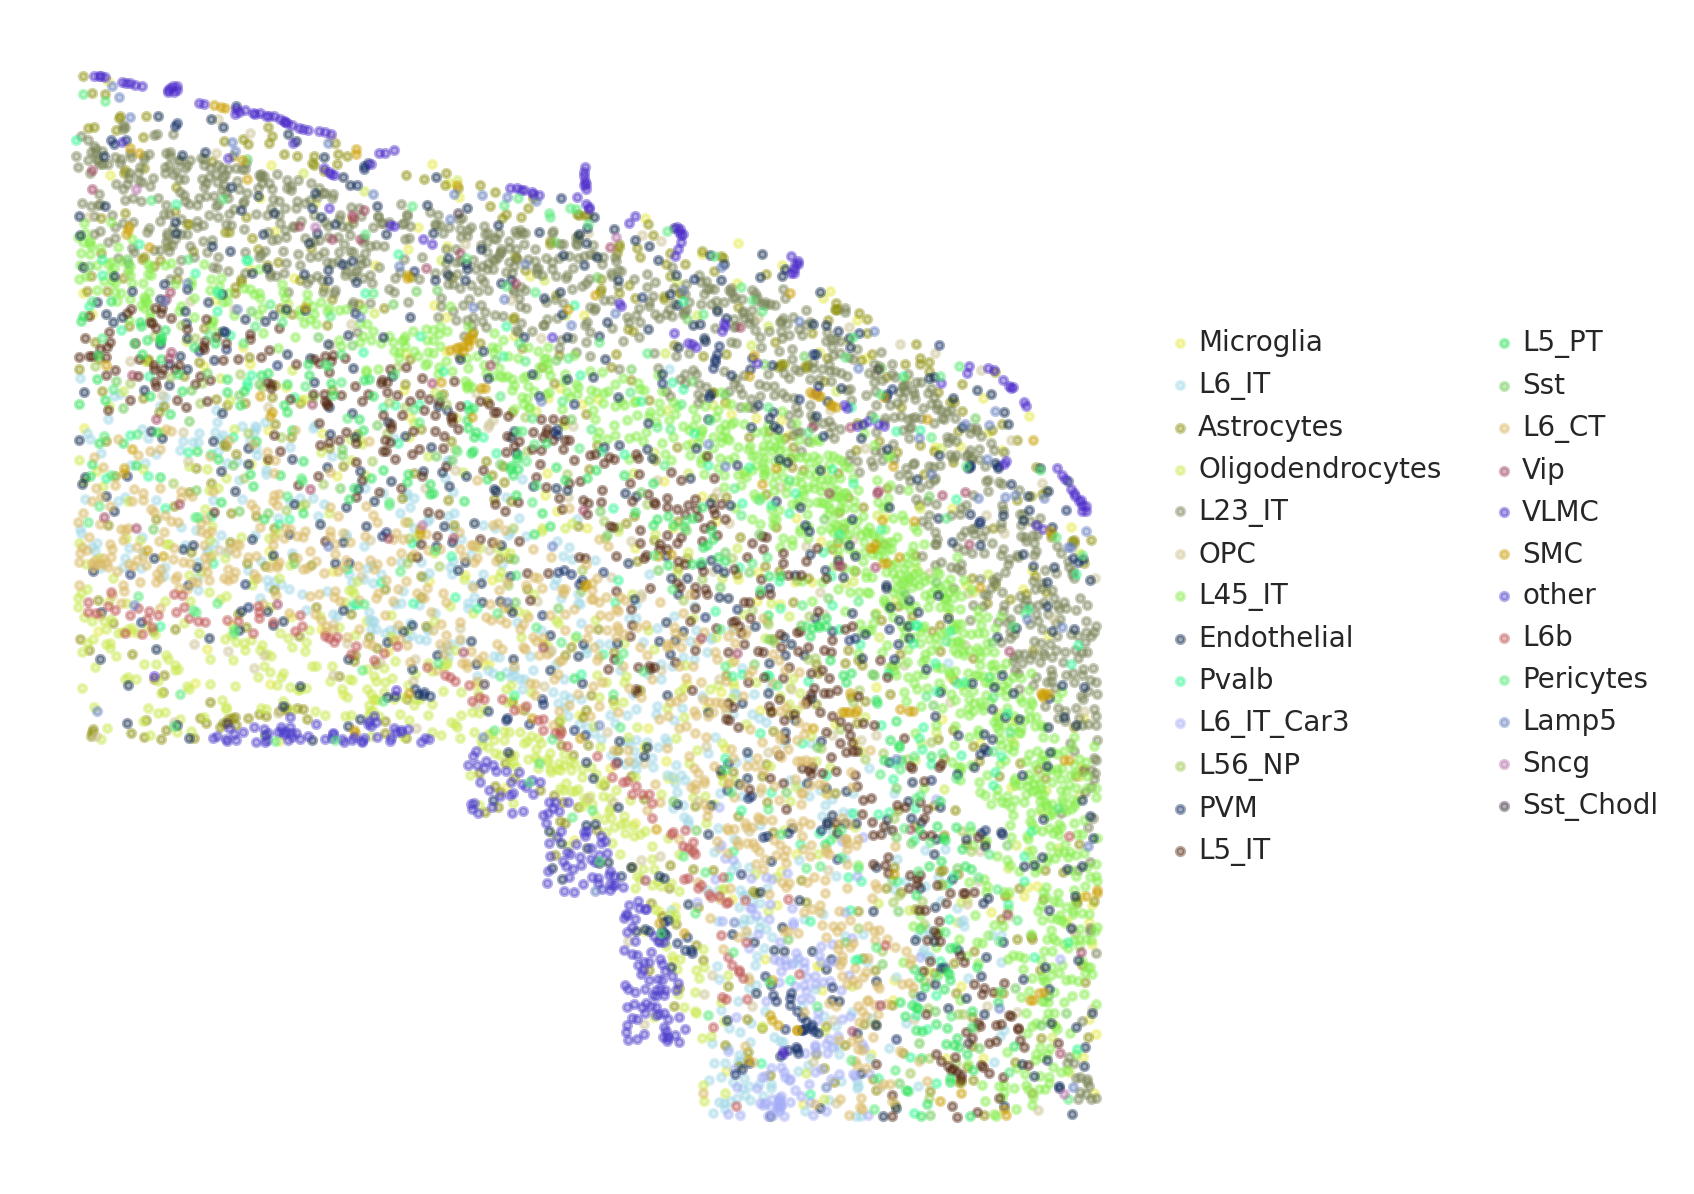

In [ ]:
vis.obj_plot_embed(labs_cont.T, labs[0], fname = '2DNCA.pdf', colors=colors )

### **Compare KNN Attributes and Prediction in Latent Space**

In [ ]:
labs_cont.shape

(2, 6963)

#### **Get prediction of cell types (discrete)**
Compare to 'baseline' latent spaces in 50D

In [ ]:
!mkdir confFigs

nnNCA fit in 2126.7751 seconds
nnNCA fit in 2099.1685 seconds
nnNCA fit in 1827.5944 seconds
nnNCA fit in 89.3475 seconds


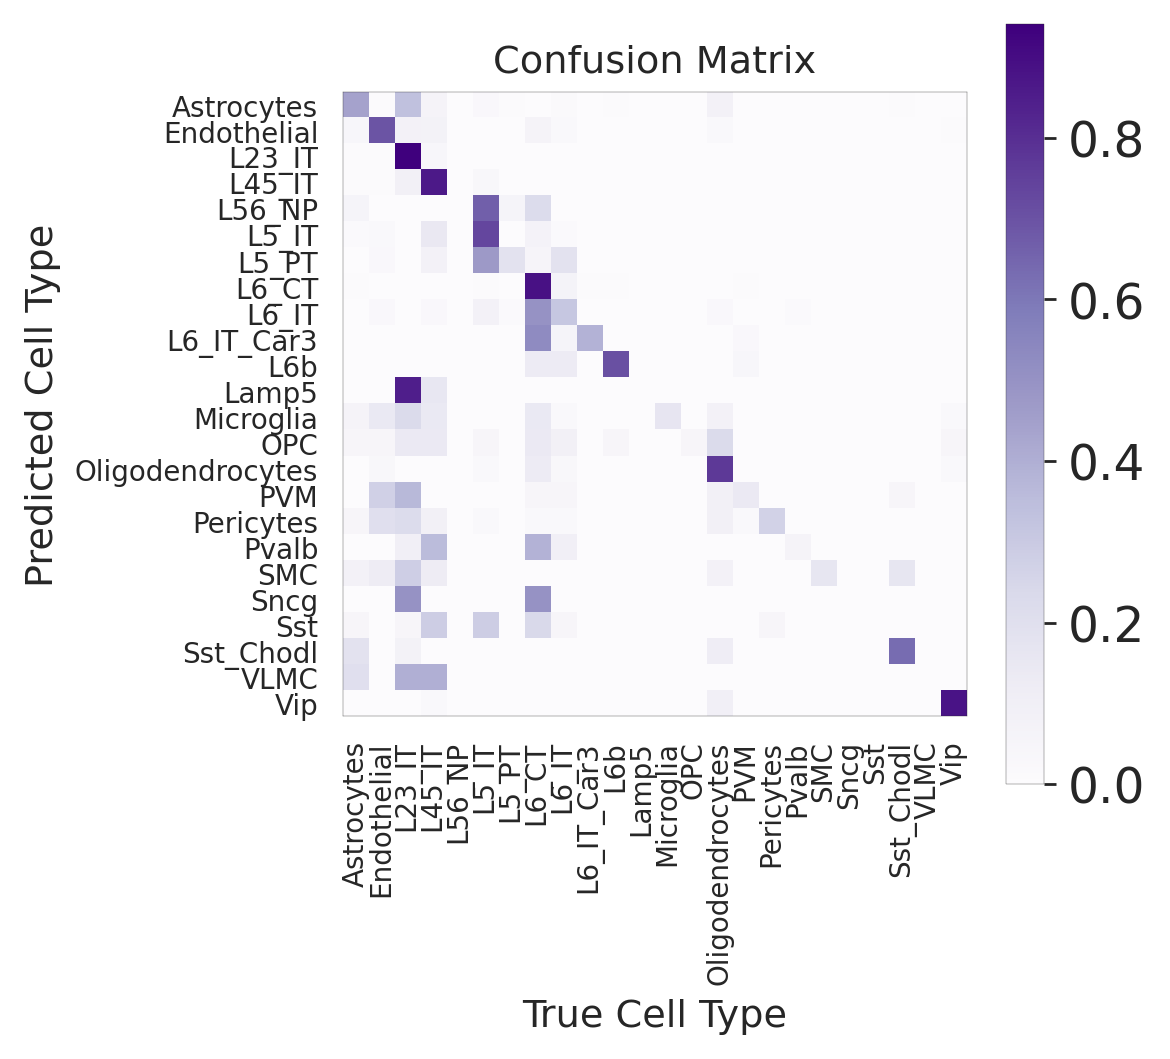

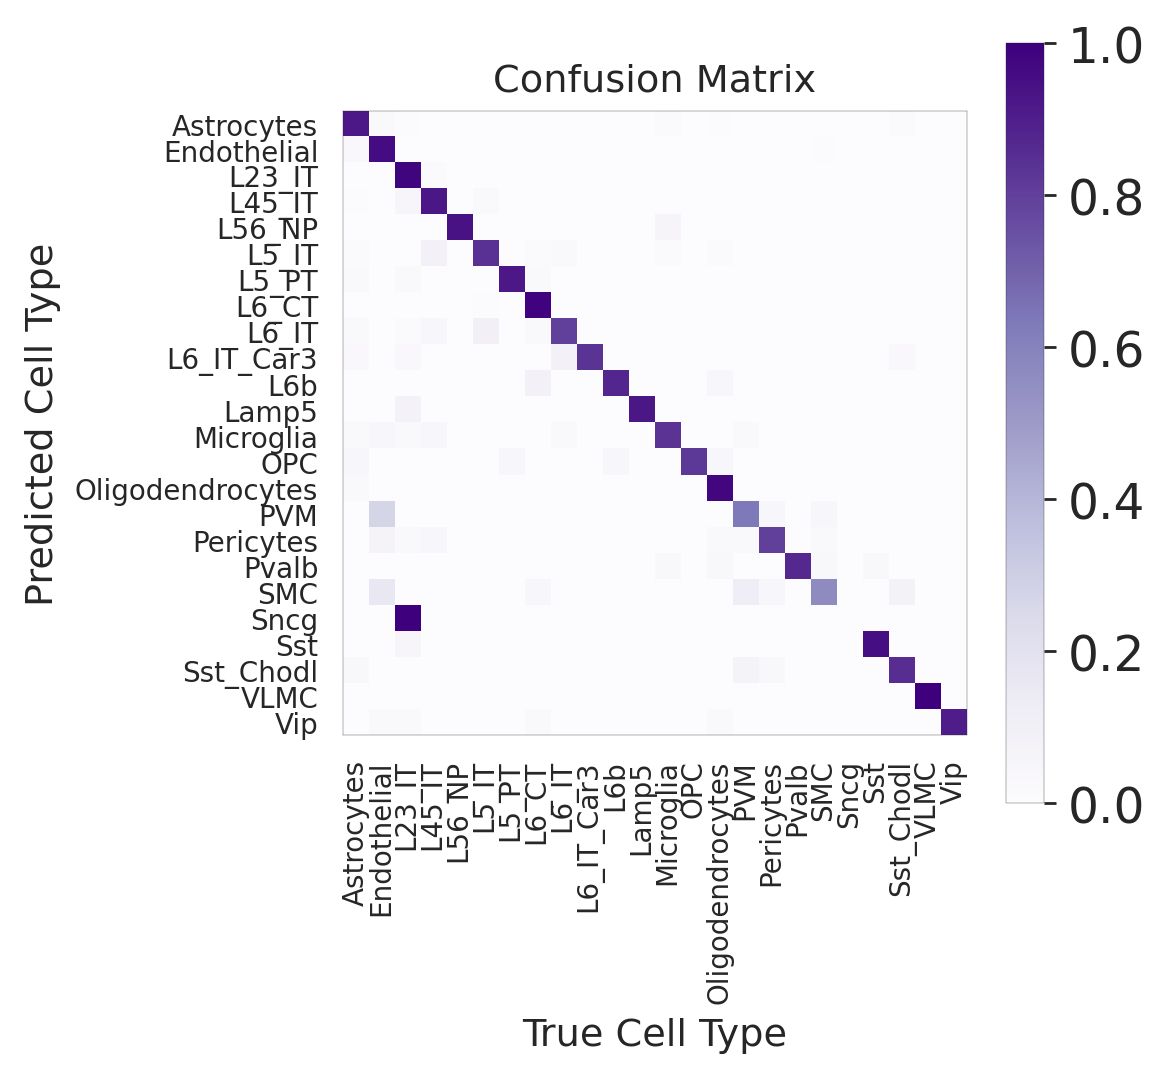

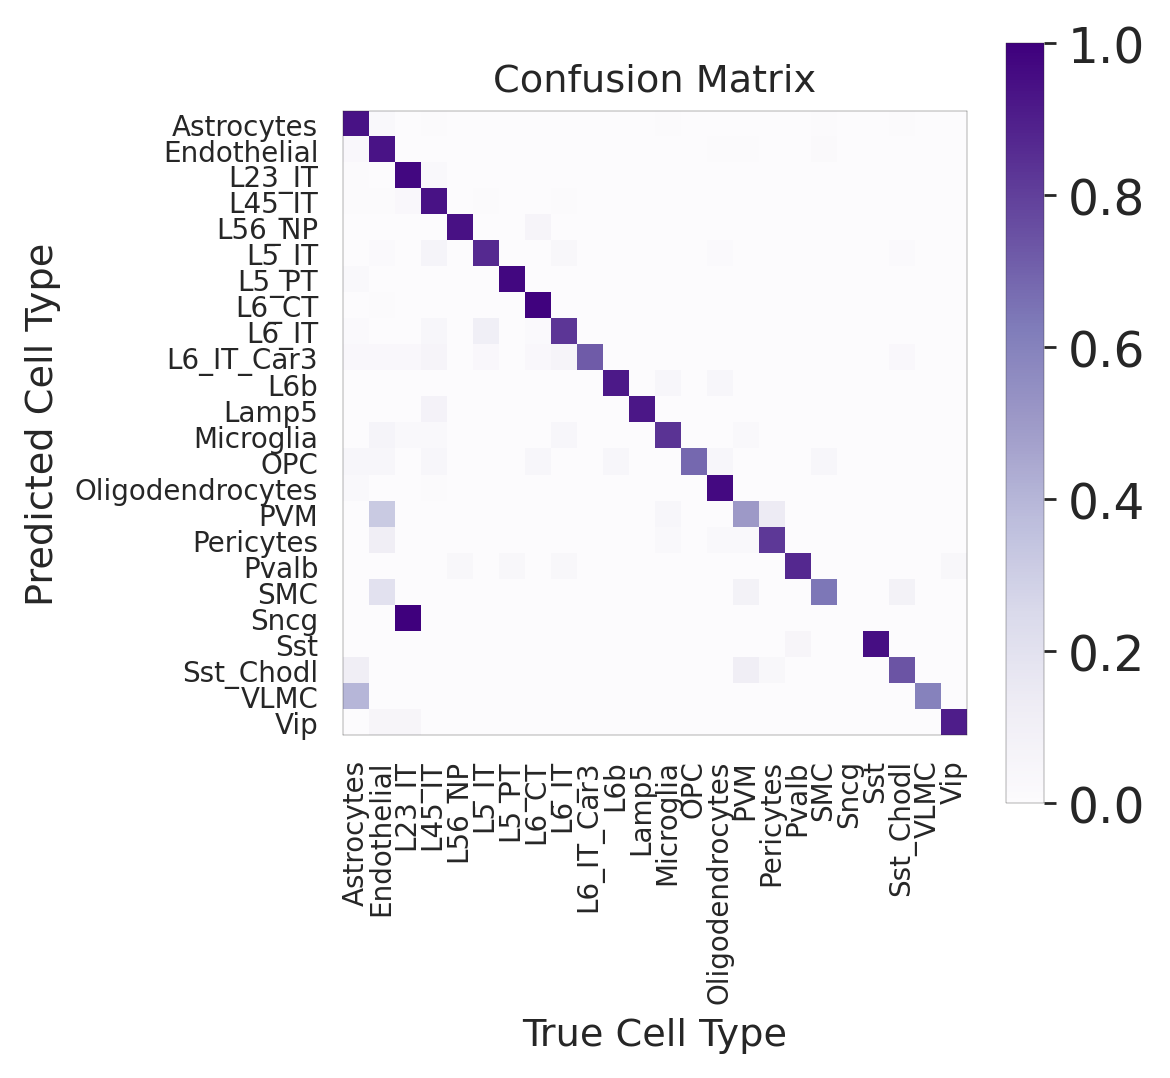

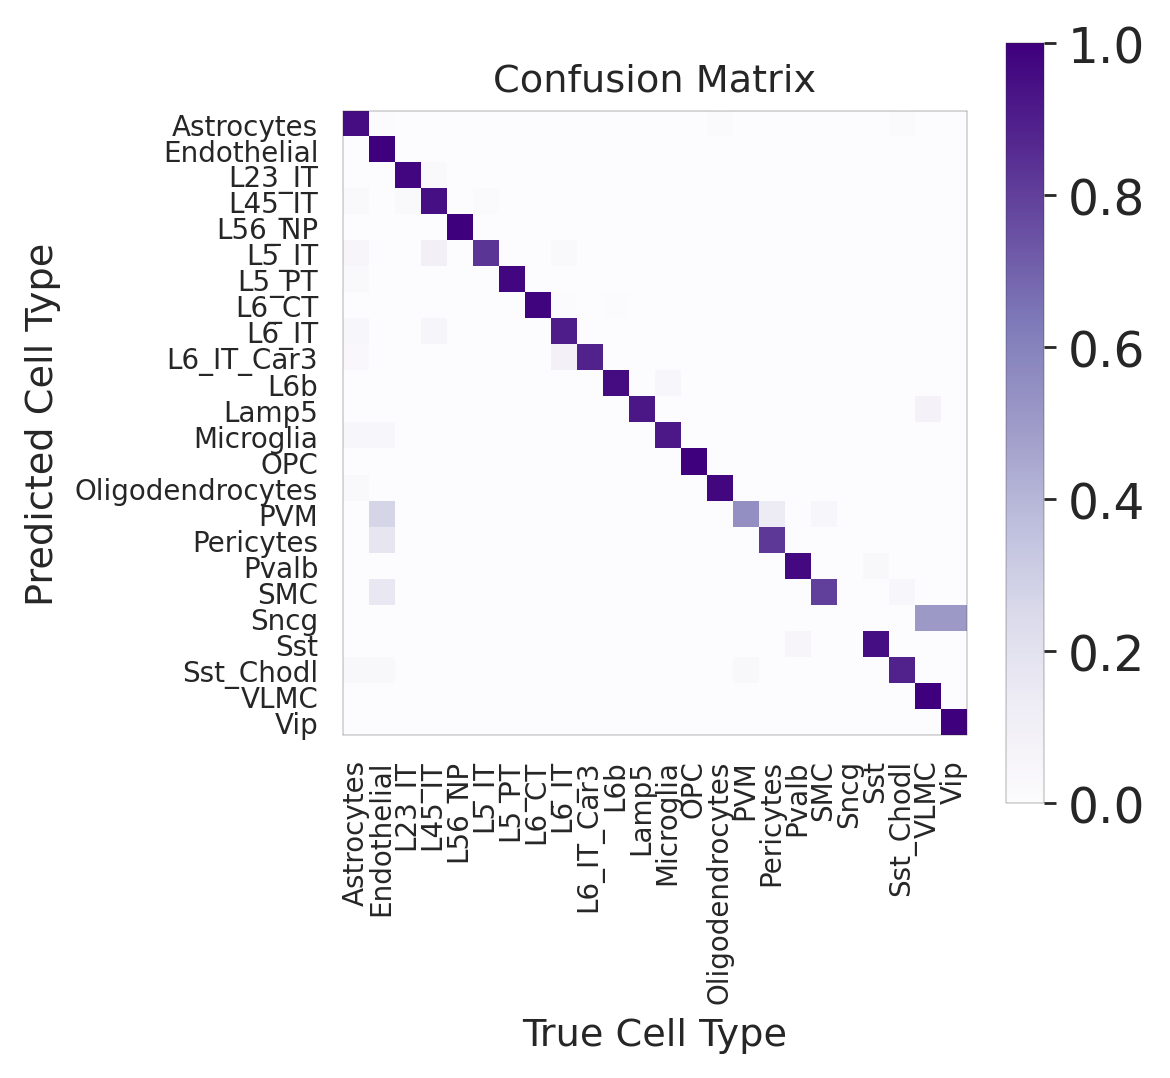

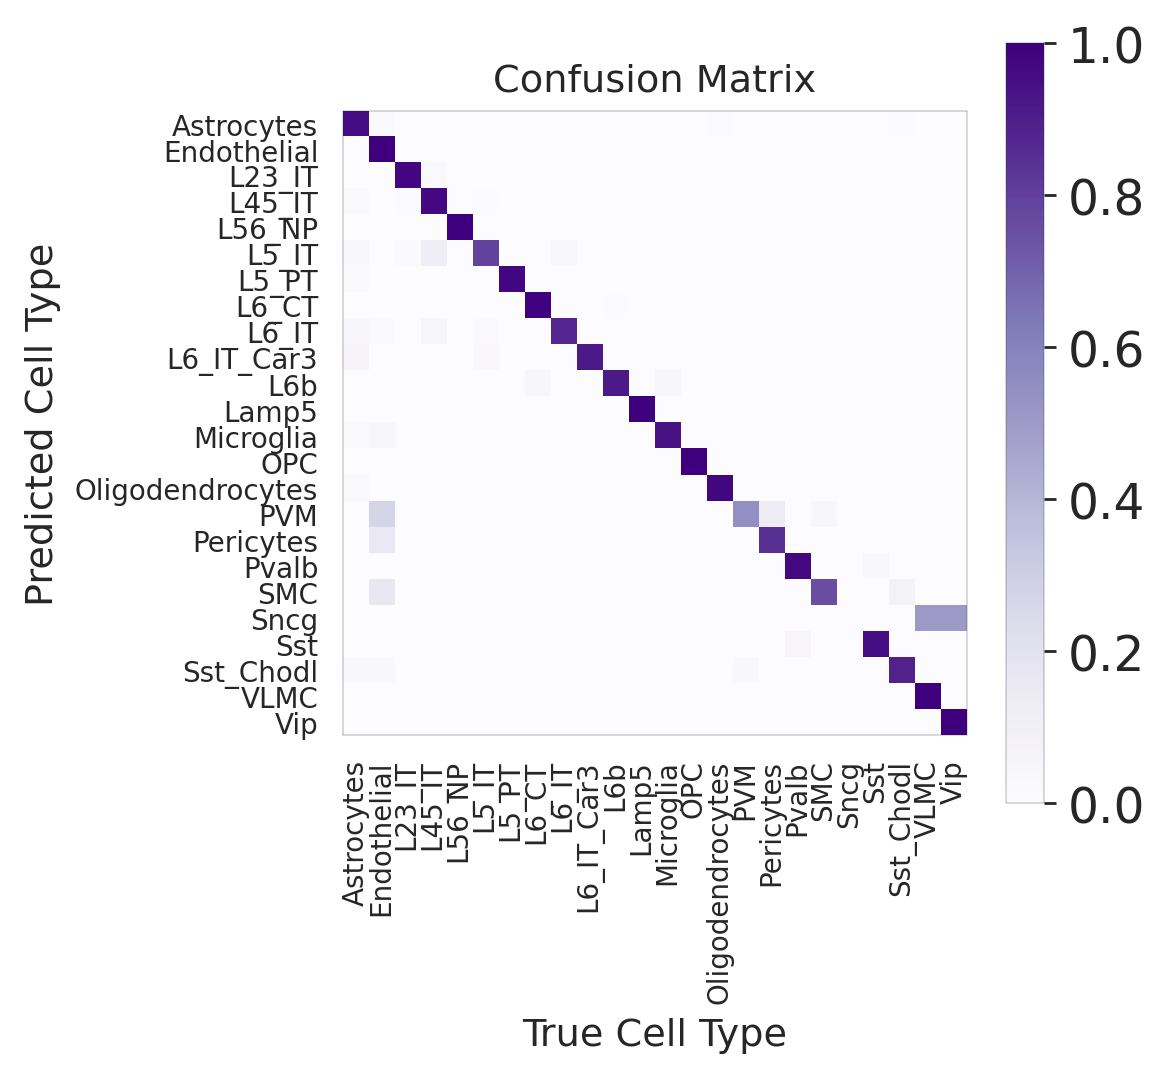

In [ ]:
#80% labeled
rounds = 1 #rounds = 3 to get error bars
unlab = []
unlabLab = []
unlabType = []

accScoreCont = []
accScoreBoth = []
accScoreType = []

accScore0 = []
accScorePCA = []

for i in range(rounds):

  numLabs = int(np.round(len(nanLabs[0])*0.8))
  allPos = range(len(nanLabs[0]))
  labeled_idx = random.sample(allPos,numLabs)
  unlabeled_idx = [i for i in allPos if i not in labeled_idx]


  labeled_lab = labs_cont.T[labeled_idx ,:]
  labeled_type = labs.T[labeled_idx ,:]

  unlabeled_lab = labs_cont.T[unlabeled_idx ,:]
  unlabeled_type = labs.T[unlabeled_idx ,:]

  newLabs = labs_cont.copy().T
  newTypes = labs.copy().T

  newLabs[unlabeled_idx,:] = np.nan
  newTypes[unlabeled_idx,:] = np.nan
  

  ncaMiss = MCML(n_latent = n_latent, epochs = 2000) #n_latent

  tic = time.perf_counter()
  lossesNCAMiss, latentNCAMiss = ncaMiss.fit(scaled_mat,nanLabs, newLabs.T,dim_cont = [2],fracNCA = 0.99, silent = True,ret_loss = True) #1
  toc = time.perf_counter()
  print(f"nnNCA fit in {toc - tic:0.4f} seconds")

  conf_matrix(latentNCAMiss, labeled_idx, labeled_type.ravel(), unlabeled_idx,unlabeled_type.ravel(),n_neighbors=50,fname='confFigs/contMat.pdf')

  #Add Dual and Type only here

  ncaBoth = MCML(n_latent = n_latent, epochs = 2000) #n_latent

  tic = time.perf_counter()
  lossesNCABoth, latentNCABoth = ncaBoth.fit(scaled_mat,newTypes.T, newLabs.T,dim_cont = [2],fracNCA = 0.99, silent = True,ret_loss = True) #1
  toc = time.perf_counter()
  print(f"nnNCA fit in {toc - tic:0.4f} seconds")
  conf_matrix(latentNCABoth, labeled_idx, labeled_type.ravel(), unlabeled_idx,unlabeled_type.ravel(),n_neighbors=50,fname='confFigs/bothMat.pdf')

  nca = MCML(n_latent = n_latent, epochs = 2000) #n_latent

  tic = time.perf_counter()
  lossesNCA, latentNCA = nca.fit(scaled_mat,newTypes.T,fracNCA = 0.99, silent = True,ret_loss = True)
  toc = time.perf_counter()
  print(f"nnNCA fit in {toc - tic:0.4f} seconds") 
  conf_matrix(latentNCA, labeled_idx, labeled_type.ravel(), unlabeled_idx,unlabeled_type.ravel(),n_neighbors=50,fname='confFigs/typeMat.pdf')



  unlab += [latentNCAMiss]
  unlabLab += ['NCA 20% Unlabeled MCML 50D']
  unlabType += ['MCML 50D']

  #Reconstruction only
  nca0 = MCML(n_latent = n_latent, epochs = 100) #n_latent

  tic = time.perf_counter()
  lossesNCA0, latentNCA0 = nca0.fit(scaled_mat,nanLabs,fracNCA = 0, silent = True,ret_loss = True)
  toc = time.perf_counter()
  print(f"nnNCA fit in {toc - tic:0.4f} seconds")
  conf_matrix(latentNCA0, labeled_idx, labeled_type.ravel(), unlabeled_idx,unlabeled_type.ravel(),n_neighbors=50,fname='confFigs/reconMat.pdf')

  # preds = knn_infer(latentNCA0, labeled_idx, labeled_type.ravel(), unlabeled_idx)
  # acc = accuracy_score(unlabeled_type.ravel(), preds)
  # accScore0.append(acc)

  tsvd = TruncatedSVD(n_components=pcs)
  x_pca = tsvd.fit_transform(scaled_mat)

  conf_matrix(x_pca, labeled_idx, labeled_type.ravel(), unlabeled_idx,unlabeled_type.ravel(),n_neighbors=50,fname='confFigs/pcaMat.pdf')

  # preds = knn_infer(x_pca, labeled_idx, labeled_type.ravel(), unlabeled_idx)
  # acc = accuracy_score(unlabeled_type.ravel(), preds)
  # accScorePCA.append(acc)


In [ ]:
from google.colab import files

!zip -r confFigs.zip confFigs/
files.download('confFigs.zip')

  adding: confFigs/ (stored 0%)
  adding: confFigs/bothMat.pdf (deflated 34%)
  adding: confFigs/pcaMat.pdf (deflated 34%)
  adding: confFigs/reconMat.pdf (deflated 34%)
  adding: confFigs/typeMat.pdf (deflated 34%)
  adding: confFigs/contMat.pdf (deflated 33%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

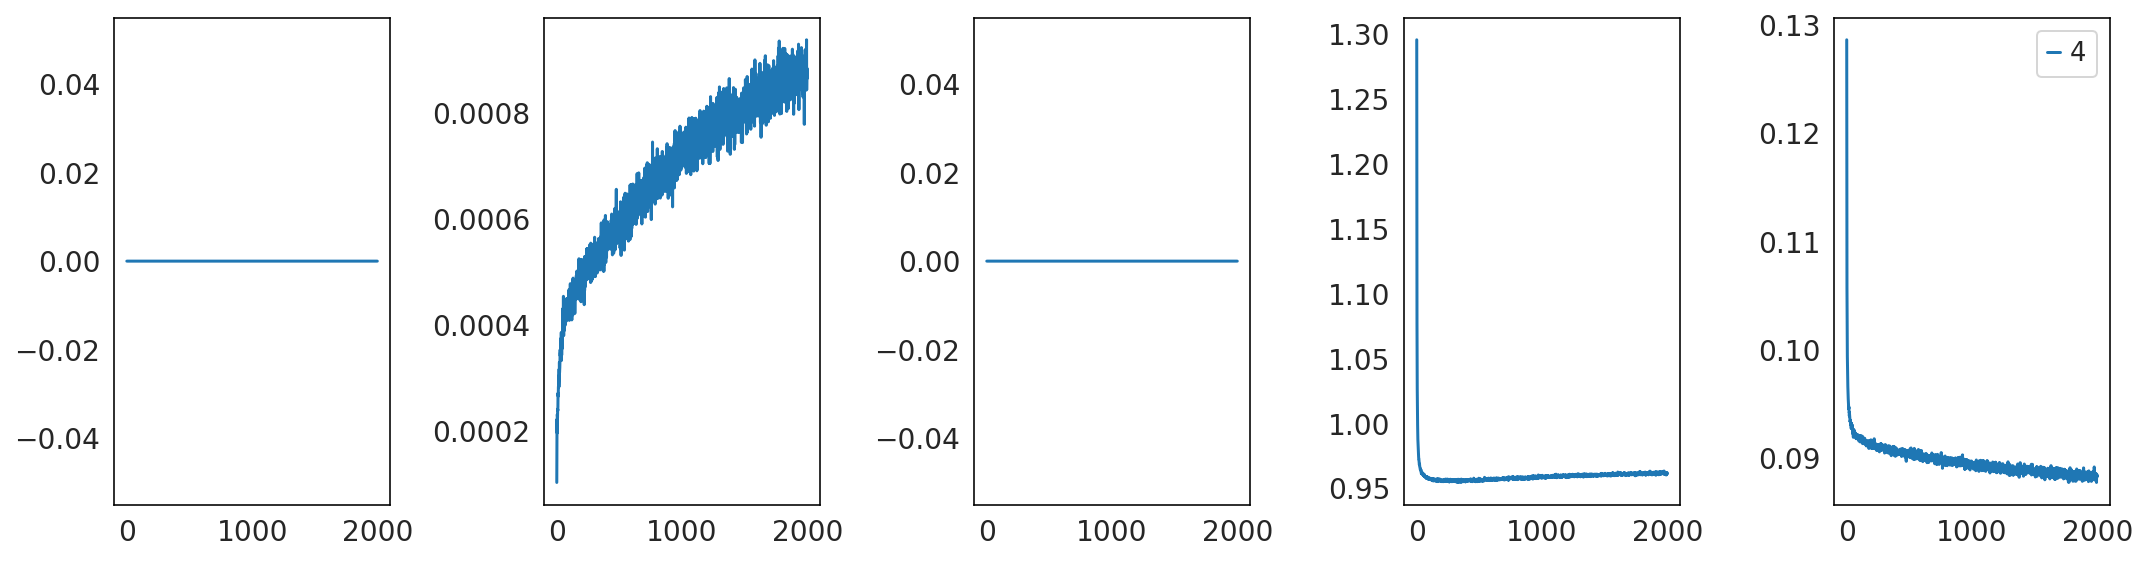

In [ ]:
fig, axs = plt.subplots(1, lossesNCAMiss.shape[1],figsize=(15,4))
for i in range(lossesNCAMiss.shape[1]):
  axs[i].plot(lossesNCAMiss[:,i],label=str(i))
  
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
vals = pd.DataFrame()

vals['Accuracy'] = accScoreCont + accScoreBoth + accScoreType + accScore0 + accScorePCA

In [ ]:
vals['Embed'] = ['Cont Only']*rounds + ['Both']*rounds + ['Type Only']*rounds + ['Recon MCML']*rounds  + ['PCA 50D']*rounds

In [ ]:
# vals['Label'] = ['CellType1']*13 + ['Gender2']*13 + ['CellType2']*4 #+  ['CellType1'] #+  ['Gender2']

In [ ]:
vals


Accuracy       Embed
0   0.631012   Cont Only
1   0.638191   Cont Only
2   0.620962   Cont Only
3   0.919598        Both
4   0.913137        Both
5   0.916009        Both
6   0.928212   Type Only
7   0.916726   Type Only
8   0.925341   Type Only
9   0.942570  Recon MCML
10  0.937545  Recon MCML
11  0.942570  Recon MCML
12  0.939698     PCA 50D
13  0.941134     PCA 50D
14  0.937545     PCA 50D

In [ ]:
from google.colab import files

vals.to_csv('allMerfishPreds.csv')
files.download('allMerfishPreds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

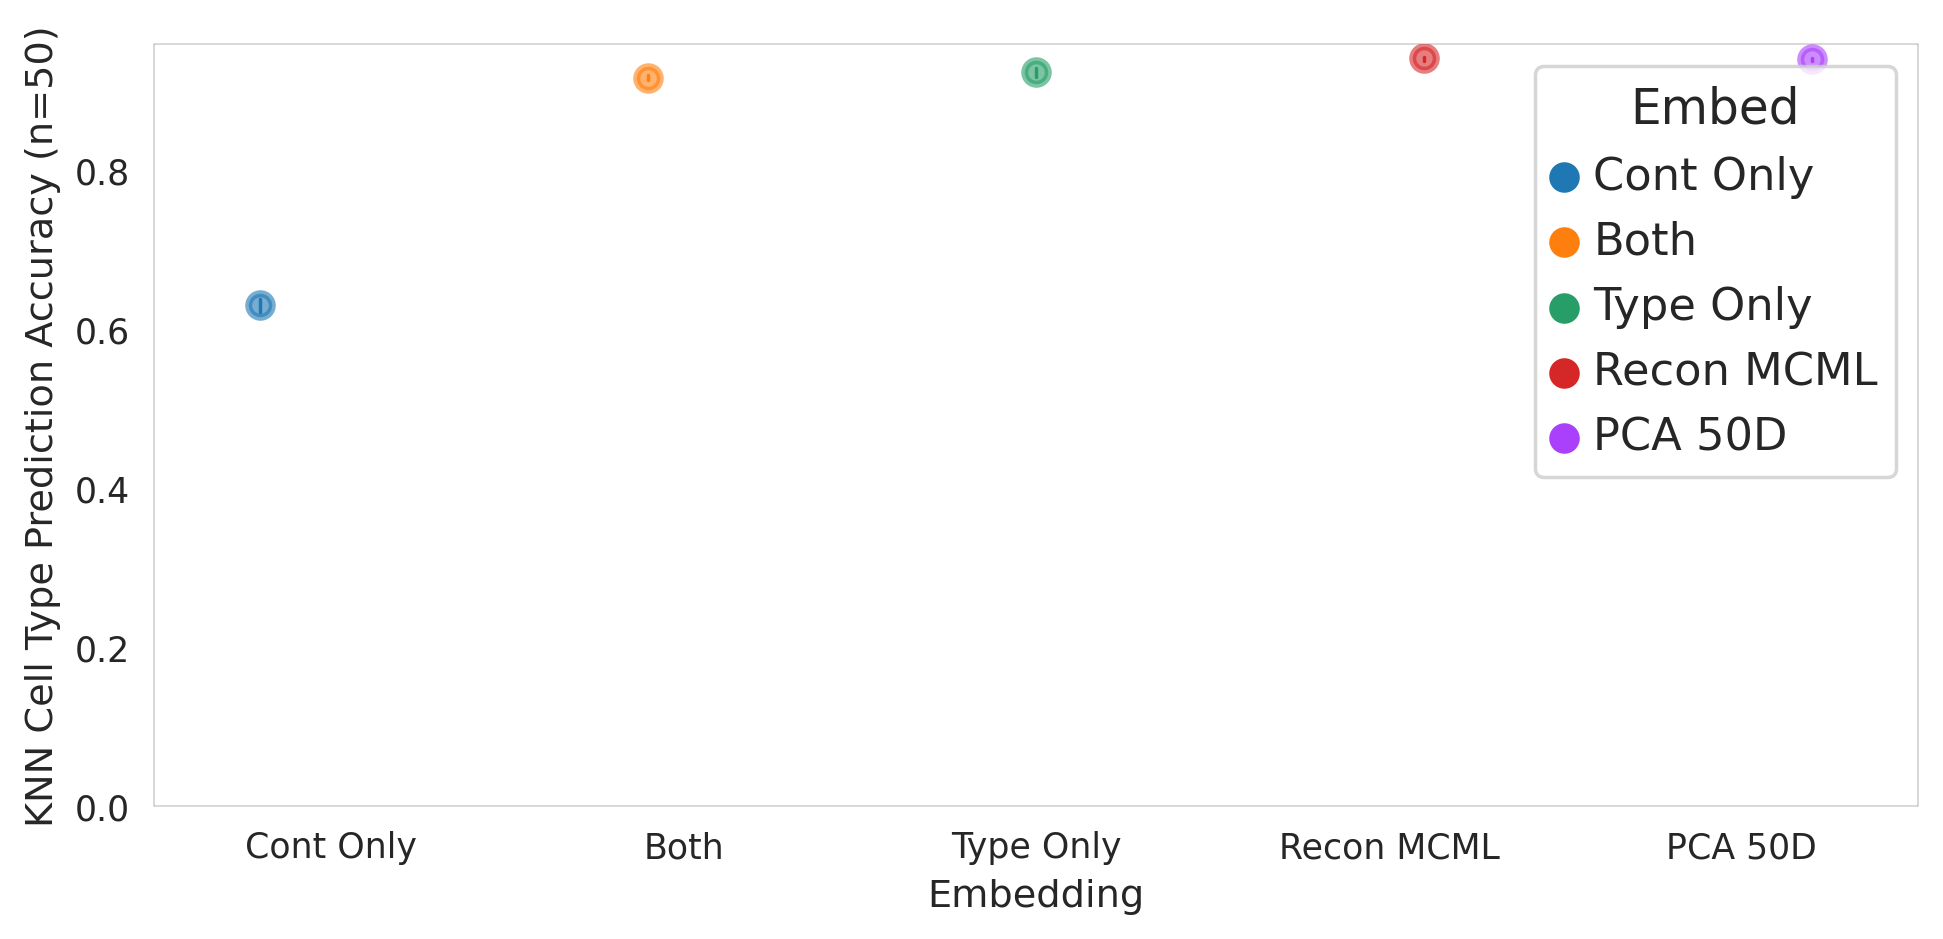

In [ ]:
plt.figure(figsize=figsize)
g=sns.pointplot(x='Embed', y='Accuracy', data=vals, hue='Embed', err_style='bars',join=False,plot_kws=dict(alpha=0.6),errwidth=errwidth, dodge=dodge,legend=False)
plt.setp(g.collections, alpha=.6) #for the markers
#plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})

plt.ylim(ymin=0)

plt.xlabel("Embedding",fontsize=axisFontSize)
plt.ylabel("KNN Cell Type Prediction Accuracy (n=50)",fontsize=axisFontSize)
plt.xticks(fontsize=tickFontSize)
plt.yticks(fontsize=tickFontSize)
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import files

vals.to_csv('allMerfishPreds.csv')
files.download('allMerfishPreds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### **KNN Prediction Comparisons to Coordinate Data**
Incorporation of spatial, cell type, and spatial + cell type class labels


In [ ]:
xs = []
ys = []
emb = []

In [ ]:
n_neighbors=50

Check overfitting (train/test loss plots)


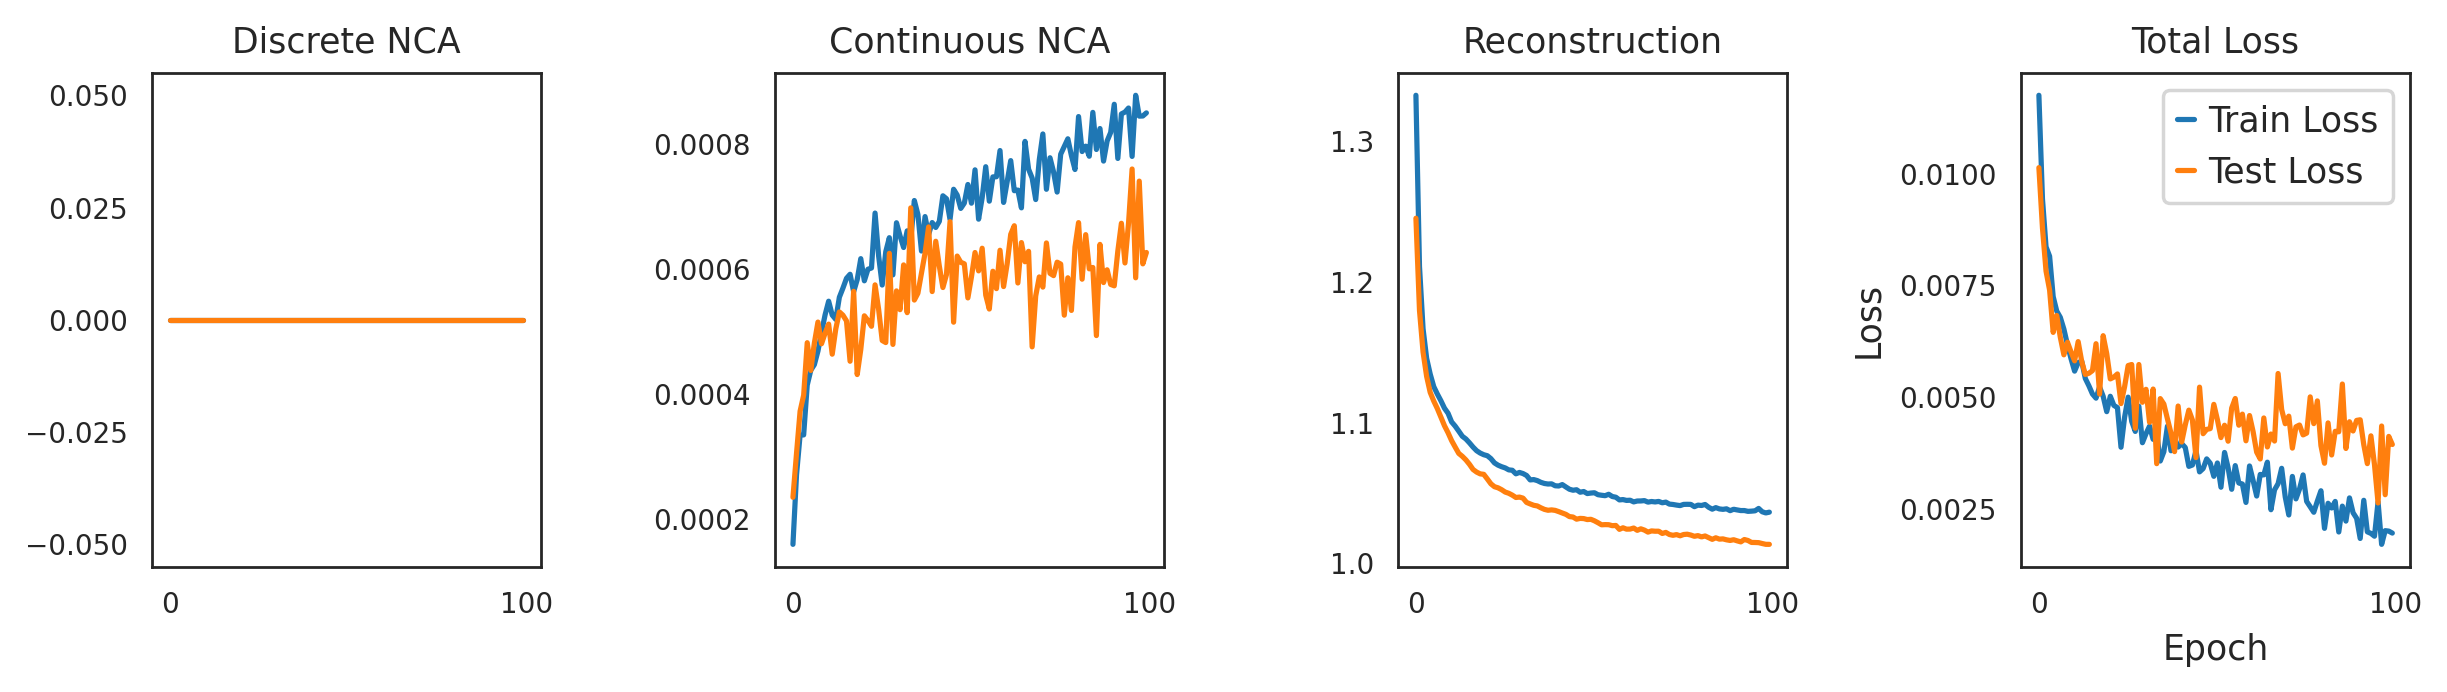

In [ ]:
nca = MCML(n_latent = n_latent, epochs = 100)

lossesTrain, lossesTest = nca.trainTest(scaled_mat,nanLabs, labs_cont.copy(),dim_cont = [2],fracNCA = 0.99, silent = True)
nca.plotLosses(figsize=(10,3),fname='merfishSpatialTrainTest.pdf',axisFontSize=10,tickFontSize=8)

Include spatial coordinate labels only (Only labeling 80% of the cells total)

In [ ]:
#80% labeled, Spatial coordinates only
rounds = 1 #rounds = 3 to get error bars
unlab = []
unlabLab = []
unlabType = []

accScoreCont = []
for i in range(rounds):
  numLabs = int(np.round(len(nanLabs[0])*0.8))
  allPos = range(len(nanLabs[0]))
  labeled_idx = random.sample(allPos,numLabs)
  unlabeled_idx = [i for i in allPos if i not in labeled_idx]


  labeled_lab = labs_cont.T[labeled_idx ,:]
  labeled_type = labs.T[labeled_idx ,:]

  unlabeled_lab = labs_cont.T[unlabeled_idx ,:]
  unlabeled_type = labs.T[unlabeled_idx ,:]

  newLabs = labs_cont.copy().T
  newTypes = labs.copy().T

  newLabs[unlabeled_idx,:] = np.nan
  newTypes[unlabeled_idx,:] = np.nan

  ncaMiss = MCML(n_latent = n_latent, epochs = 2000) #n_latent

  tic = time.perf_counter()
  lossesNCAMiss, latentNCAMiss = ncaMiss.fit(scaled_mat,nanLabs, newLabs.T,dim_cont = [2],fracNCA = 0.99, silent = True,ret_loss = True) #1
  toc = time.perf_counter()
  print(f"nnNCA fit in {toc - tic:0.4f} seconds")

  unlab += [latentNCAMiss]
  unlabLab += ['NCA 20% Unlabeled MCML 50D']
  unlabType += ['MCML 50D']

  preds = knn_infer(latentNCAMiss, labeled_idx, labeled_type.ravel(), unlabeled_idx)
  acc = accuracy_score(unlabeled_type.ravel(), preds)
  accScoreCont.append(acc)



nnNCA fit in 3045.9825 seconds


In [ ]:
accScoreCont

[0.6080402010050251]

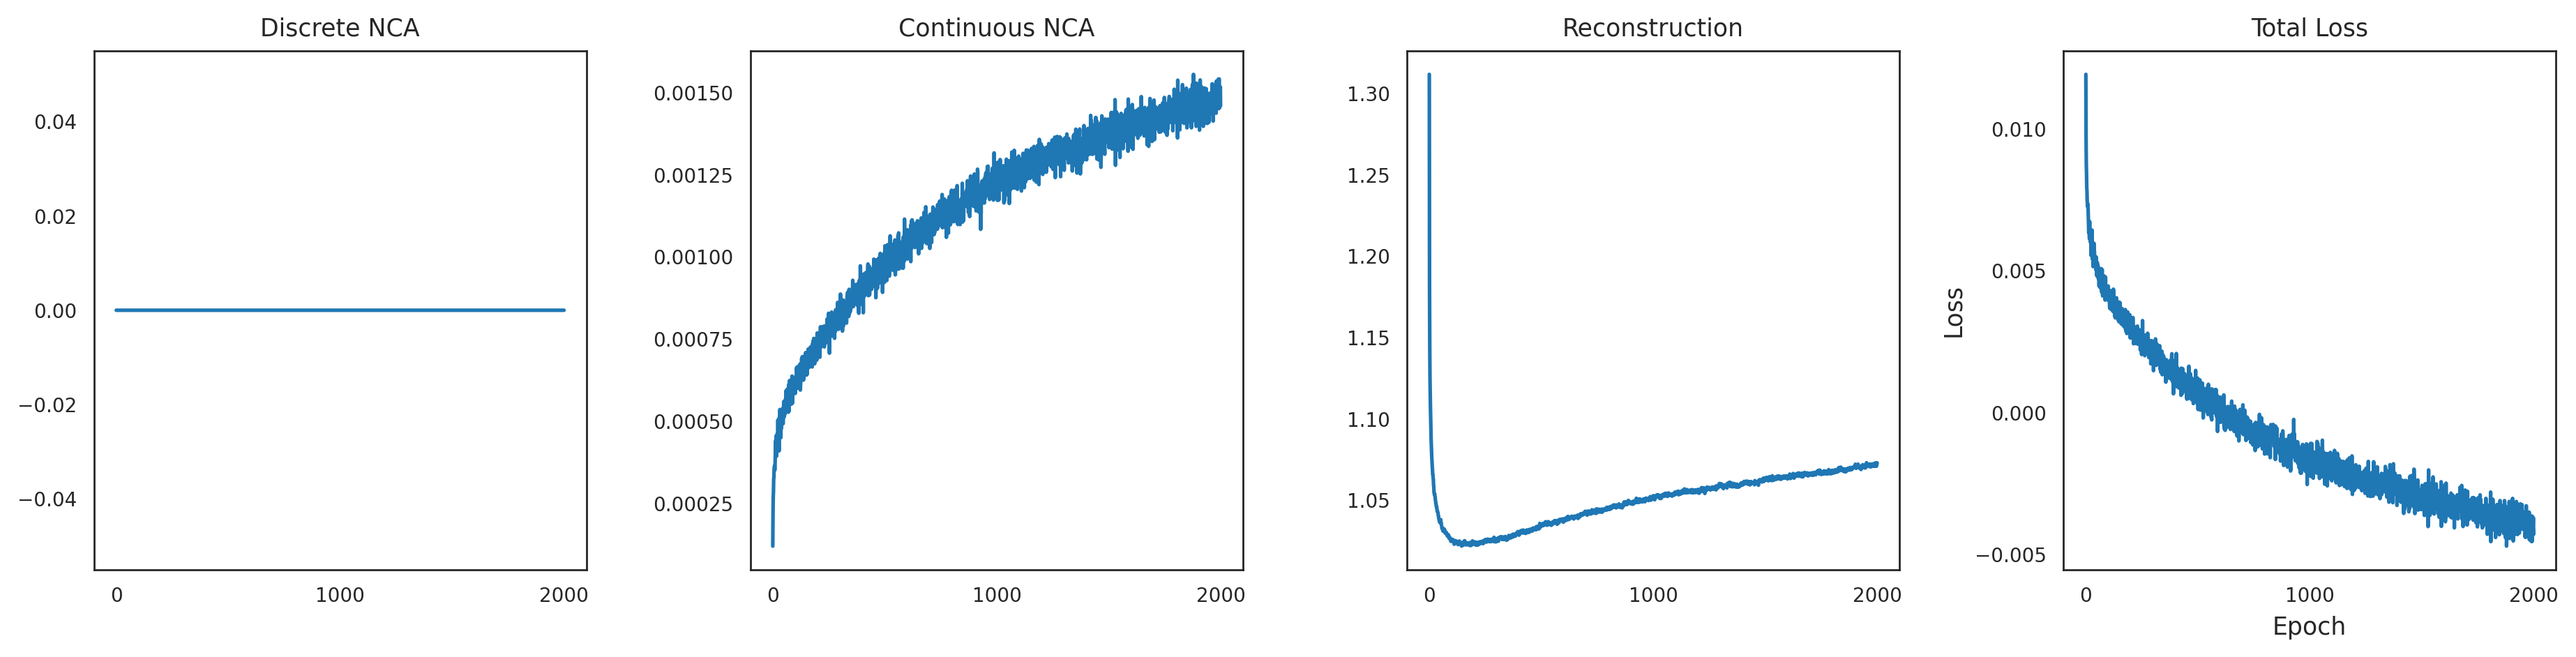

In [ ]:
ncaMiss.plotLosses(figsize=(15,4),fname=None,axisFontSize=10,tickFontSize=8)

Combine discrete and continuous labels for prediction

In [ ]:
#80% labeled
rounds = 1 #rounds = 3 to get error bars
bothlab = []
bothLab = []
bothType = []
accScoreBoth=[]
for i in range(rounds):

  ncaBoth = MCML(n_latent = n_latent, epochs = 2000) #n_latent

  tic = time.perf_counter()
  lossesNCABoth, latentNCABoth = ncaBoth.fit(scaled_mat,newTypes.T, newLabs.T,dim_cont = [2],fracNCA = 0.99, silent = True,ret_loss = True) #1
  toc = time.perf_counter()
  print(f"nnNCA fit in {toc - tic:0.4f} seconds")

  bothlab += [latentNCABoth]
  bothLab += ['Dual NCA 20% Unlabeled MCML 50D']
  bothType += ['MCML 50D']

  preds = knn_infer(latentNCABoth, labeled_idx, labeled_type.ravel(), unlabeled_idx)
  acc = accuracy_score(unlabeled_type.ravel(), preds)
  accScoreBoth.append(acc)




nnNCA fit in 3111.5922 seconds


In [ ]:
accScoreBoth

[0.9045226130653267]

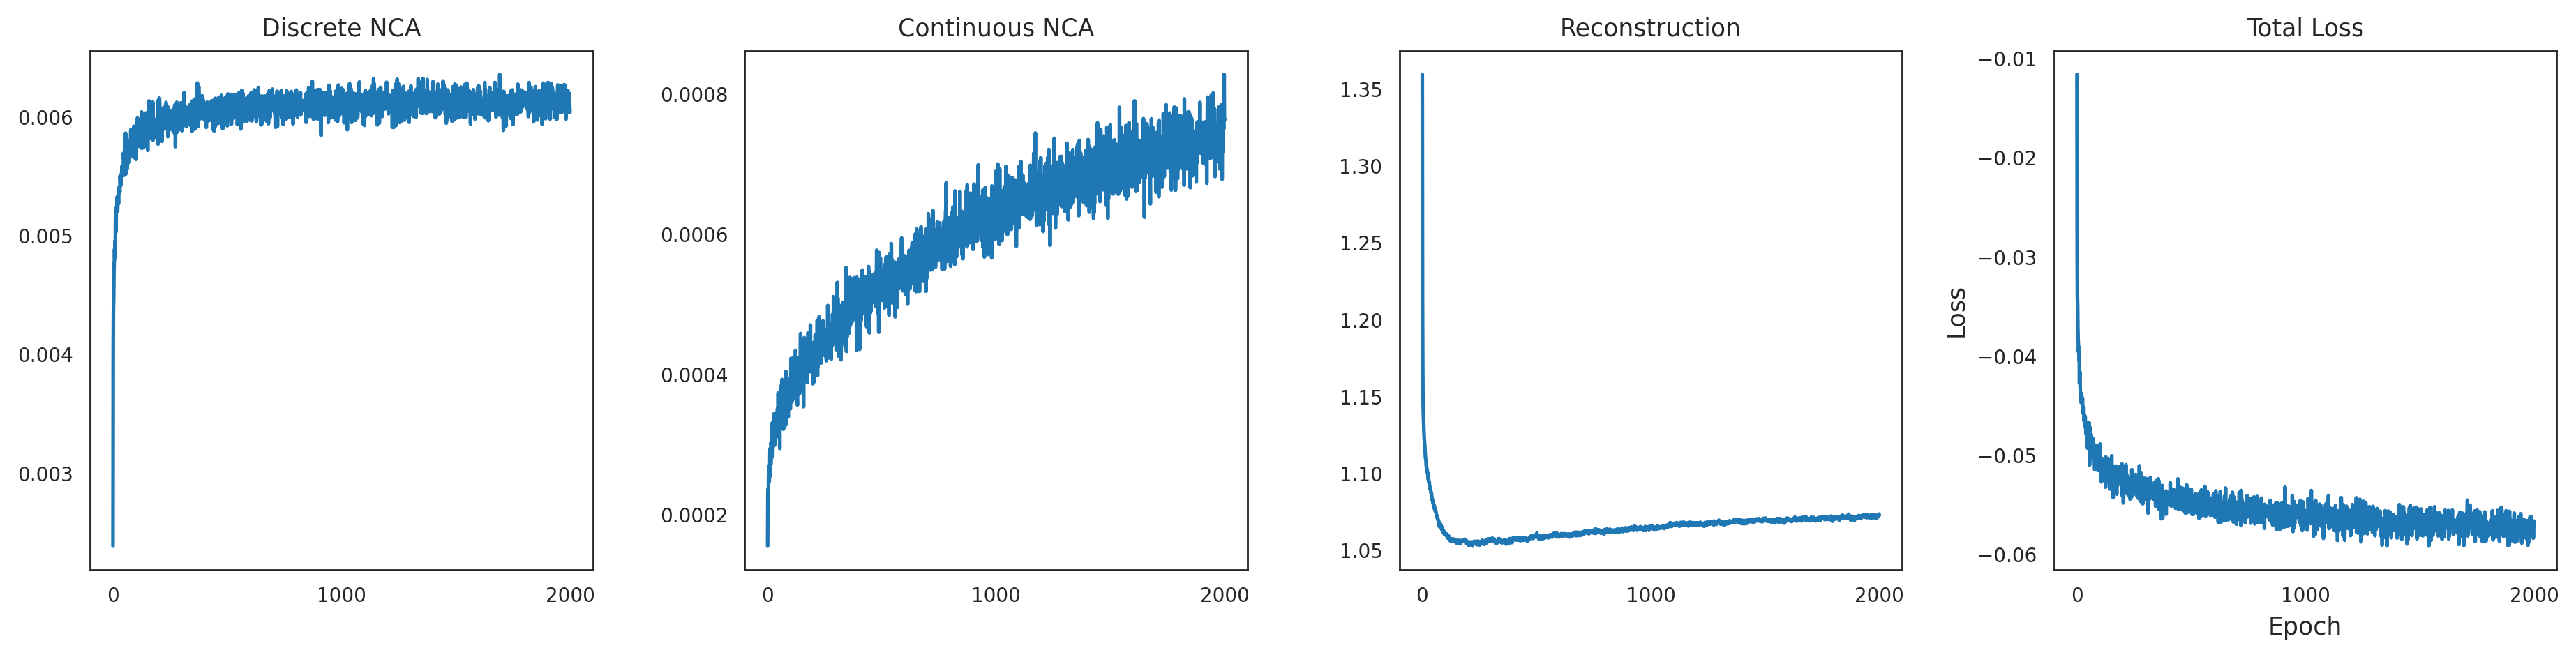

In [ ]:
ncaBoth.plotLosses(figsize=(15,4),fname=None,axisFontSize=10,tickFontSize=8)

Include cell type labels only

In [ ]:
#Include cell type, show KNNs for pseudotime after and KNNs for cell type 
cell = []
cellLab = []
cellType = []
accScoreType = []
for i in range(rounds):

  nca = MCML(n_latent = n_latent, epochs = 2000) #n_latent

  tic = time.perf_counter()
  lossesNCA, latentNCA = nca.fit(scaled_mat,newTypes.T,fracNCA = 0.99, silent = True,ret_loss = True)
  toc = time.perf_counter()
  print(f"nnNCA fit in {toc - tic:0.4f} seconds") 

  cell += [latentNCA]
  cellLab += ['Type NCA 20% Unlabeled MCML 50D']
  cellType += ['MCML 50D']

  preds = knn_infer(latentNCA, labeled_idx, labeled_type.ravel(), unlabeled_idx)
  acc = accuracy_score(unlabeled_type.ravel(), preds)
  accScoreType.append(acc)



nnNCA fit in 2713.1651 seconds


In [ ]:
accScoreType

[0.914572864321608]

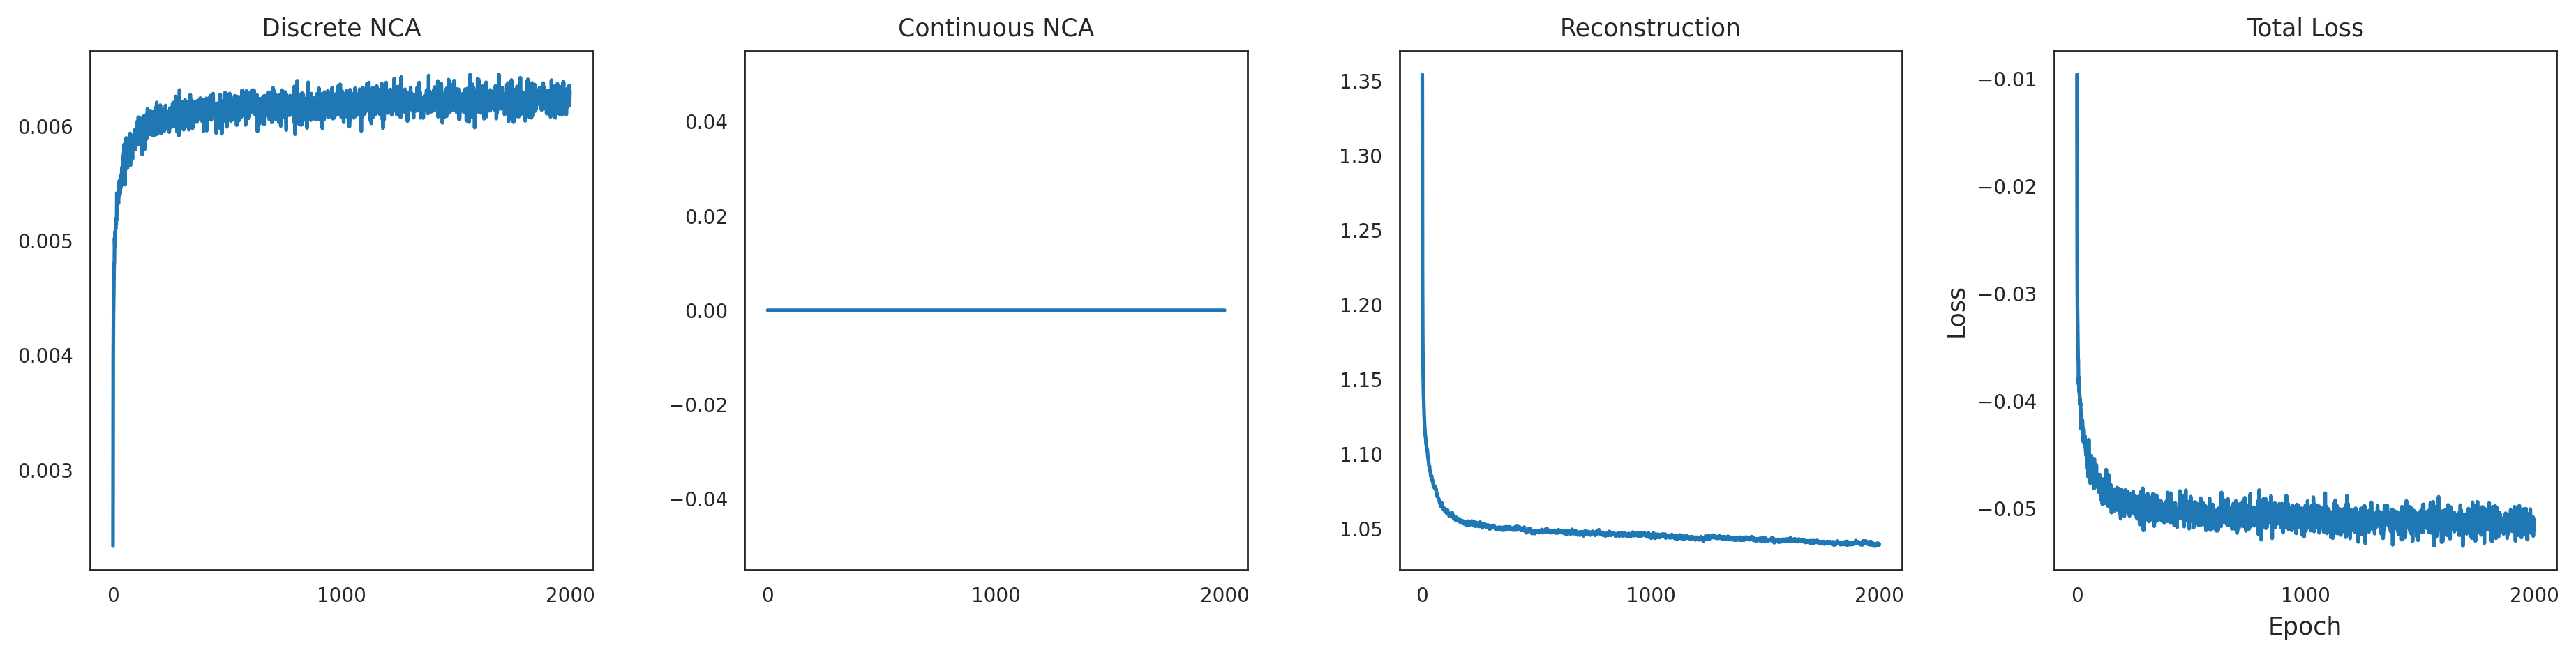

In [ ]:
nca.plotLosses(figsize=(15,4),fname=None,axisFontSize=10,tickFontSize=8)

Get 'baseline' embeddings for comparison

In [ ]:
latents,latentLab,latentType = reconComp(scaled_mat, ndims=2, pcs=50)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
latents = cell + bothlab + unlab + latents #[3:] #[1:]

latentLab = cellLab + bothLab + unlabLab + latentLab #[3:] #[1:]

latentType = cellType + bothType + unlabType + latentType #[3:] #[1:]

In [ ]:
len(latents)

12

Get (spatial) neighbors in ambient space

In [ ]:
orig_indices = tl.getNeighbors(labs_cont.T, n_neigh = 50,p=2)

In [ ]:
emb = []

xs = []

ys = []

knnDF = pd.DataFrame()

for p in range(len(latents)):
  i = latents[p]
  l = latentLab[p]

  ind = tl.getNeighbors(i, n_neigh = n_neighbors,p=2)

  x,y = tl.ecdf(tl.getJaccard(orig_indices,ind))

  xs += list(x)
  ys += list(y)

  emb += [l]*len(x)

  print(l)

  print(np.mean(tl.getJaccard(orig_indices,ind)))



knnDF['x'] = xs
knnDF['y'] = ys
knnDF['latent'] = emb



Type NCA 20% Unlabeled MCML 50D
0.9700339368303784
Dual NCA 20% Unlabeled MCML 50D
0.9082557630302527
NCA 20% Unlabeled MCML 50D
0.814591751473145
Recon MCML 50D
0.9600626976557118
PCA 50D
0.9597500635028641
PCA t-SNE
0.9617953220894776
PCA UMAP
0.9604942893362028
Recon MCML 50D
0.9597889855445255
PCA 50D
0.9595337037660641
PCA t-SNE
0.9612310618431888
PCA UMAP
0.9602050733477816
Recon MCML 50D
0.9597269074909026
PCA 50D
0.9597898612731856
PCA t-SNE
0.9616422023687345
PCA UMAP
0.9609517079672957


In [ ]:
knnDF[(knnDF['y'] < 0.50) & (knnDF['latent'].isin(['NCA 20% Unlabeled MCML 50D']))]

x         y                      latent
13926  0.387097  0.000000  NCA 20% Unlabeled MCML 50D
13927  0.412698  0.000144  NCA 20% Unlabeled MCML 50D
13928  0.412698  0.000287  NCA 20% Unlabeled MCML 50D
13929  0.412698  0.000431  NCA 20% Unlabeled MCML 50D
13930  0.412698  0.000574  NCA 20% Unlabeled MCML 50D
...         ...       ...                         ...
17403  0.837209  0.499354  NCA 20% Unlabeled MCML 50D
17404  0.837209  0.499497  NCA 20% Unlabeled MCML 50D
17405  0.837209  0.499641  NCA 20% Unlabeled MCML 50D
17406  0.837209  0.499785  NCA 20% Unlabeled MCML 50D
17407  0.837209  0.499928  NCA 20% Unlabeled MCML 50D

[3482 rows x 3 columns]

In [ ]:
# sub = knnDF[~knnDF['latent'].isin(['Recon MCML 50D','PCA 50D','PCA UMAP']) ]

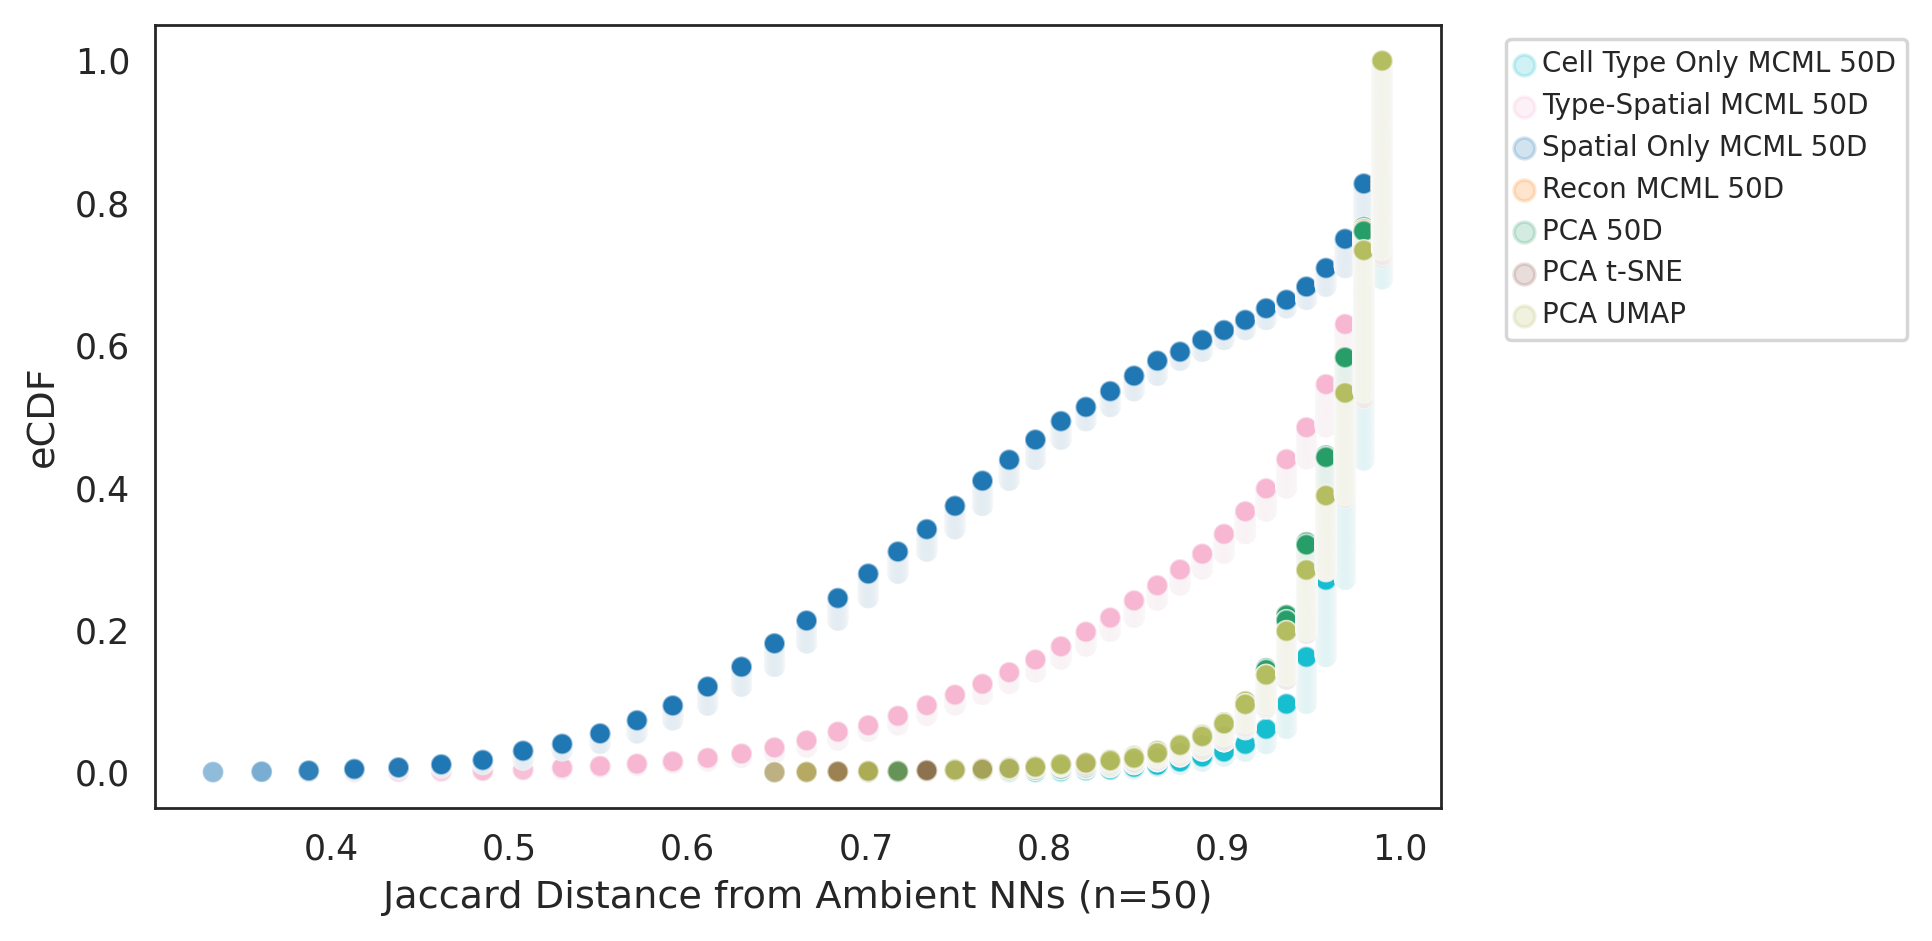

In [ ]:
#All labeled data
plt.figure(figsize=(8,4))
g=sns.scatterplot(data=knnDF, x='x', y='y', hue='latent',palette={"NCA 20% Unlabeled MCML 50D":sns.color_palette()[0],"Recon MCML 50D":sns.color_palette()[1],
                  "PCA 50D":sns.color_palette()[2],"PCA 2D":sns.color_palette()[3],"Recon MCML TSNE":sns.color_palette()[4],"PCA t-SNE":sns.color_palette()[5],
                  "Recon MCML UMAP":sns.color_palette()[6],"PCA UMAP":sns.color_palette()[7],
                  "Type NCA 20% Unlabeled MCML 50D":sns.color_palette()[8],"Dual NCA 20% Unlabeled MCML 50D":sns.color_palette()[15]})
plt.setp(g.collections, alpha=.2) #for the markers

current_handles, current_labels = plt.gca().get_legend_handles_labels()

plt.legend(current_handles,['Cell Type Only MCML 50D','Type-Spatial MCML 50D','Spatial Only MCML 50D',
                            'Recon MCML 50D','PCA 50D','PCA t-SNE','PCA UMAP'],
           bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":8})

plt.xlabel("Jaccard Distance from Ambient NNs (n=50)",fontsize=11)
plt.ylabel("eCDF",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

In [ ]:
sub = knnDF[~knnDF['latent'].isin(['PCA 2D']) ]

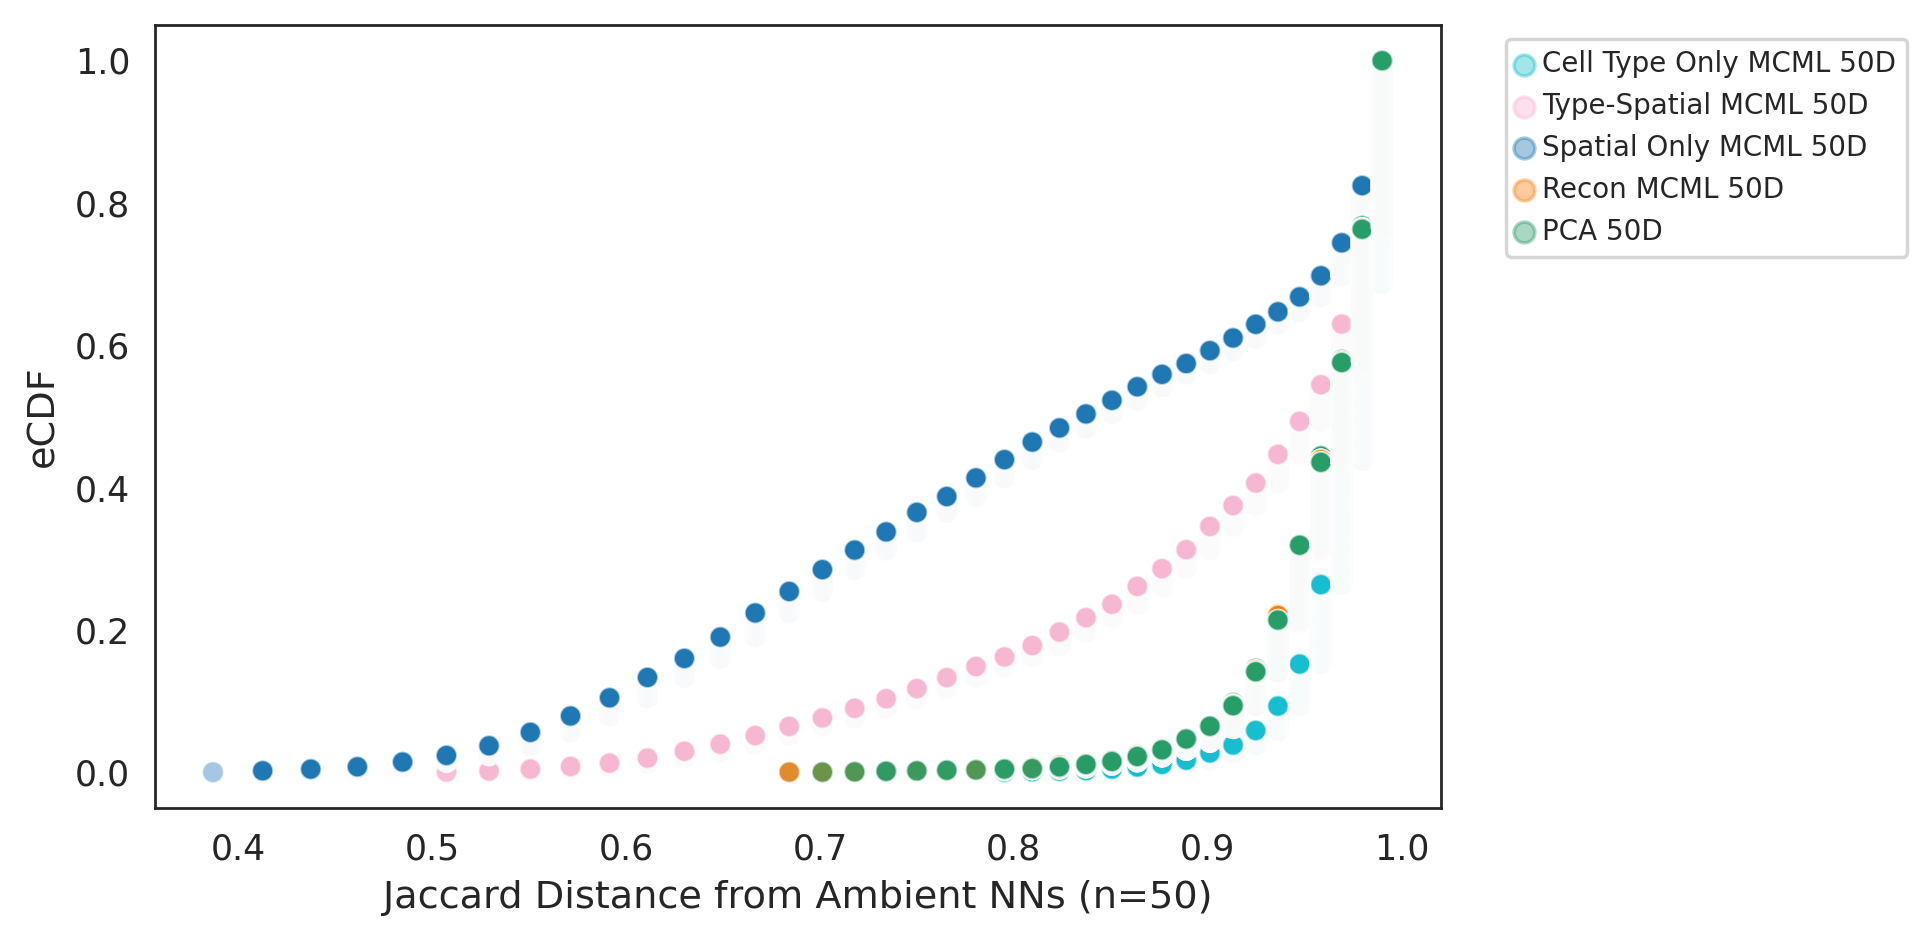

In [ ]:
#All labeled data
plt.figure(figsize=(8,4))
g=sns.scatterplot(data=sub, x='x', y='y', hue='latent',palette={"NCA 20% Unlabeled MCML 50D":sns.color_palette()[0],"Recon MCML 50D":sns.color_palette()[1],
                  "PCA 50D":sns.color_palette()[2],"PCA 2D":sns.color_palette()[3],"Recon MCML TSNE":sns.color_palette()[4],"PCA t-SNE":sns.color_palette()[5],
                  "Recon MCML UMAP":sns.color_palette()[6],"PCA UMAP":sns.color_palette()[7],
                  "Type NCA 20% Unlabeled MCML 50D":sns.color_palette()[8],"Dual NCA 20% Unlabeled MCML 50D":sns.color_palette()[15]})
plt.setp(g.collections, alpha=.4) #for the markers

current_handles, current_labels = plt.gca().get_legend_handles_labels()

plt.legend(current_handles,['Cell Type Only MCML 50D','Type-Spatial MCML 50D','Spatial Only MCML 50D',
                            'Recon MCML 50D','PCA 50D'],
           bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":8})

plt.xlabel("Jaccard Distance from Ambient NNs (n=50)",fontsize=11)
plt.ylabel("eCDF",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

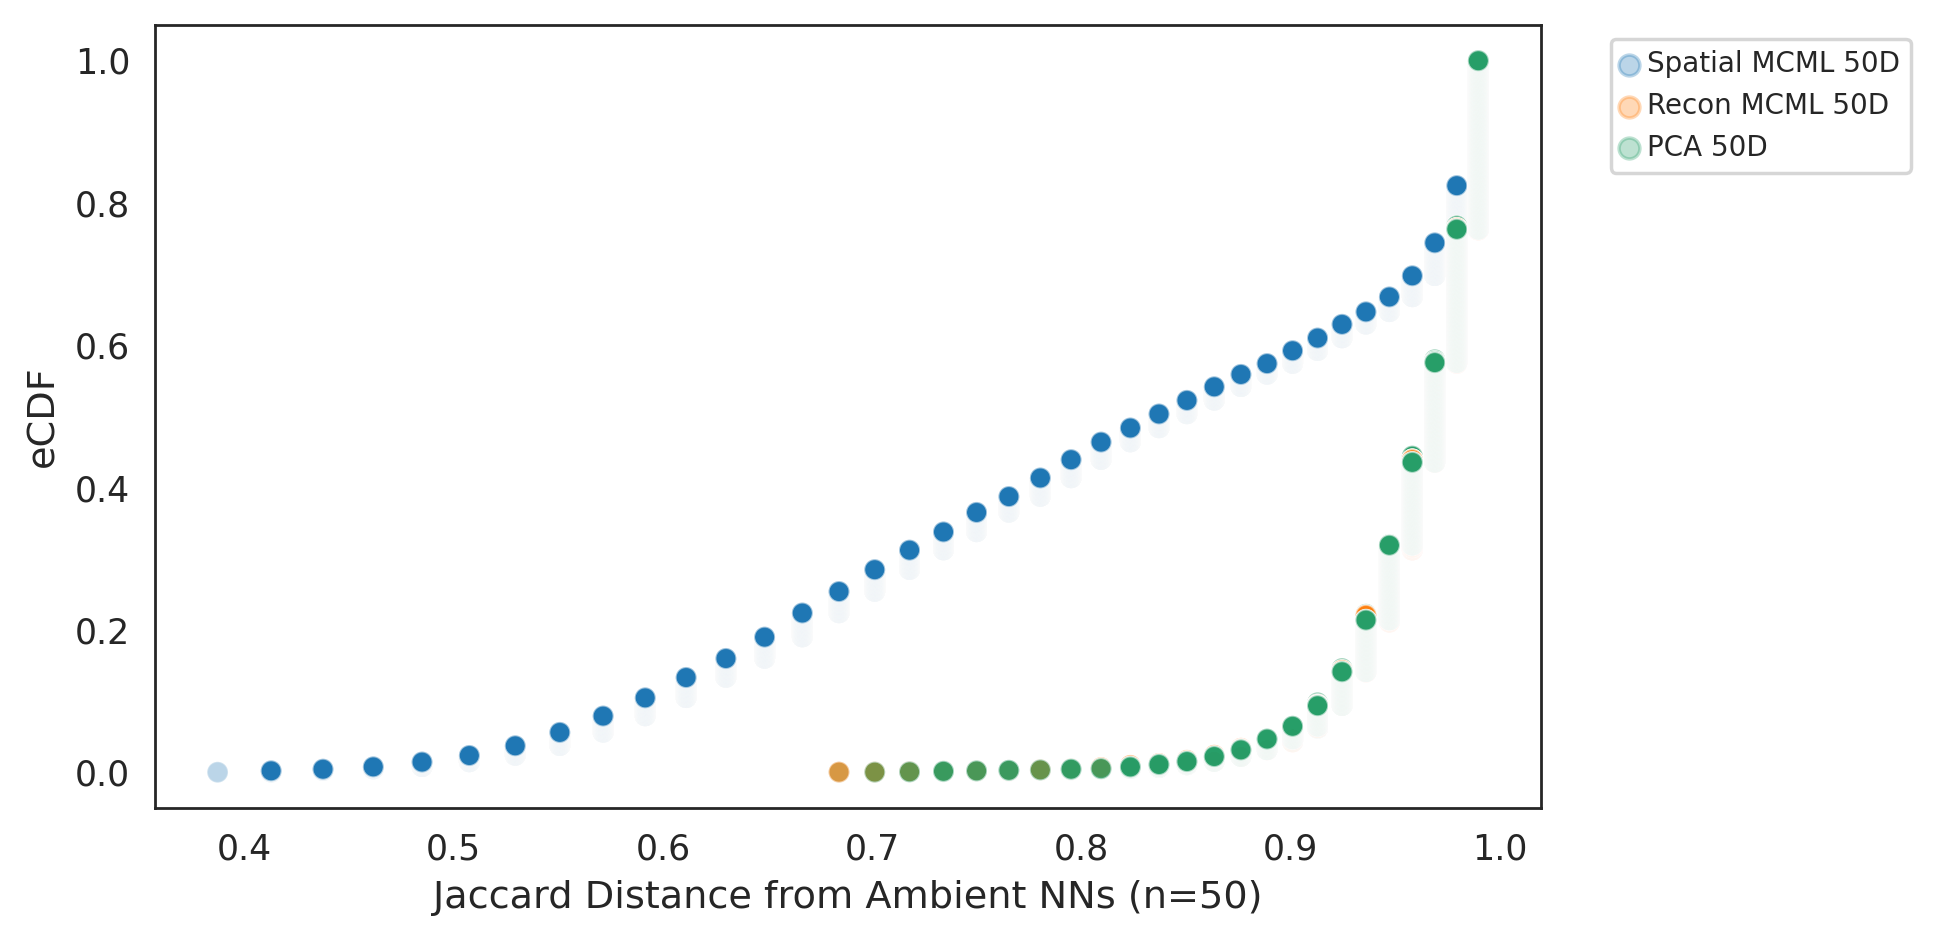

In [ ]:
#No 'Dual' Plot
subDual = sub[~sub['latent'].isin(['Dual NCA 20% Unlabeled MCML 50D','Type NCA 20% Unlabeled MCML 50D']) ]

plt.figure(figsize=(8,4))
g=sns.scatterplot(data=subDual, x='x', y='y', hue='latent',palette={"NCA 20% Unlabeled MCML 50D":sns.color_palette()[0],"Recon MCML 50D":sns.color_palette()[1],
                  "PCA 50D":sns.color_palette()[2],"PCA 2D":sns.color_palette()[3],"Recon MCML TSNE":sns.color_palette()[4],"PCA TSNE":sns.color_palette()[5],
                  "Recon MCML UMAP":sns.color_palette()[6],"PCA UMAP":sns.color_palette()[7],
                  "Type NCA 20% Unlabeled MCML 50D":sns.color_palette()[8],"Dual NCA 20% Unlabeled MCML 50D":sns.color_palette()[15]})
plt.setp(g.collections, alpha=.3) #for the markers

current_handles, current_labels = plt.gca().get_legend_handles_labels()

plt.legend(current_handles,['Spatial MCML 50D',
                            'Recon MCML 50D','PCA 50D'],
           bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":8})

plt.xlabel("Jaccard Distance from Ambient NNs (n=50)",fontsize=11)
plt.ylabel("eCDF",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

Test Position Prediction

In [ ]:
emb = []

xs = []

ys = []


subL = latents #[0:]
subLLab = latentLab #[0:]
for p in range(len(subL)):
  i = subL[p]
  l = subLLab[p]

  preds = knnReg_infer(i, labeled_idx, labeled_lab, unlabeled_idx,n_neighbors=n_neighbors) #tl.

  x = np.linalg.norm(preds -  unlabeled_lab,axis=1)

  xs += list(x)


  emb += [l]*len(x)



knnDF = pd.DataFrame()

knnDF['x'] = xs

knnDF['latent'] = emb

knnDF['logx'] = np.log(knnDF['x'])

In [ ]:
for i in np.unique(knnDF['latent']):
  logxs = knnDF['x'][knnDF['latent'].isin([i])]
  print(i)
  #print(np.log(statistics.mode(logxs)))
  print(np.mean(logxs))

Dual NCA 20% Unlabeled MCML 50D
623.9162836839175
NCA 20% Unlabeled MCML 50D
571.0831416482712
PCA 50D
702.8574601430641
PCA UMAP
706.0587509945751
PCA t-SNE
726.172972665289
Recon MCML 50D
704.1744685843429
Type NCA 20% Unlabeled MCML 50D
754.8233478676159


In [ ]:
sub = knnDF[~knnDF.latent.isin(['PCA 2D'])]


In [ ]:
for i in ['Type NCA 20% Unlabeled MCML 50D','Dual NCA 20% Unlabeled MCML 50D','NCA 20% Unlabeled MCML 50D','Recon MCML 50D','PCA 50D']:
  logxs = sub['x'][sub['latent'].isin([i])]
  print(i)
  #print(np.log(statistics.mode(logxs)))
  print(np.mean(logxs))

Type NCA 20% Unlabeled MCML 50D
771.3892313379552
Dual NCA 20% Unlabeled MCML 50D
629.430418913291
NCA 20% Unlabeled MCML 50D
603.3445261435589
Recon MCML 50D
706.8987951839307
PCA 50D
706.8030192636875


In [ ]:
percs = {}
for i in ['Dual NCA 20% Unlabeled MCML 50D','NCA 20% Unlabeled MCML 50D']:
  logxs = np.mean(sub['x'][sub['latent'].isin([i])])

  logxsPCA = np.mean(sub['x'][sub['latent'].isin(['Recon MCML 50D'])])
  logxsRecon = np.mean(sub['x'][sub['latent'].isin(['PCA 50D'])])

  percs[i] = [(logxs-logxsPCA)/logxsPCA,(logxs-logxsRecon)/logxsRecon ]
  #print(np.log(statistics.mode(logxs)))
  
print(percs)

{'Dual NCA 20% Unlabeled MCML 50D': [-0.10958906253402645, -0.10946840667290791], 'NCA 20% Unlabeled MCML 50D': [-0.1464909400693314, -0.14637528462725935]}


Get avg (spatial) distance between 50 NNs for each cell

In [ ]:
avg = 0
for i in range(len(orig_indices)):
  d = pairwise_distances(labs_cont.T[orig_indices[i][1:],:])
  avg += np.mean(d[d!=0])

avg = avg/len(orig_indices)

Get avg (spatial) distance between all pairs of cells

In [ ]:
allD = pairwise_distances(labs_cont.T)

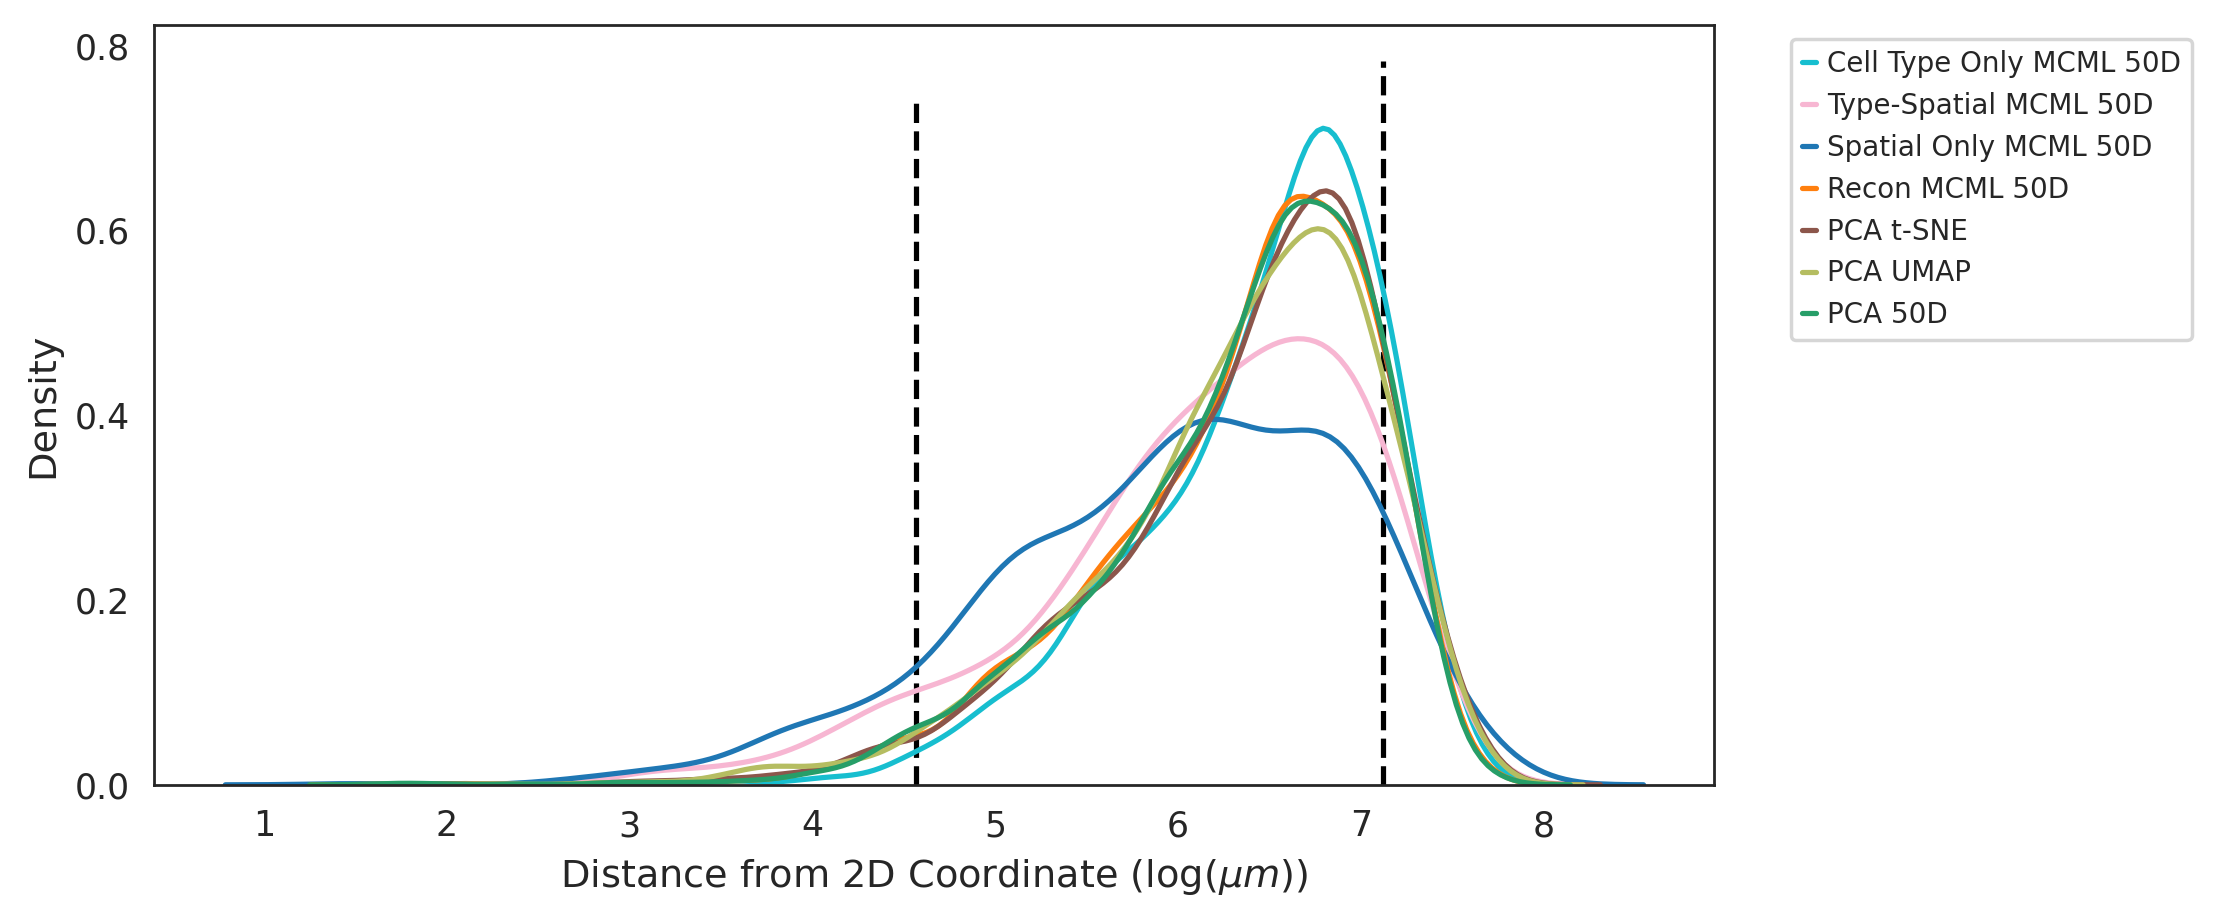

In [ ]:
palette={"NCA 20% Unlabeled MCML 50D":sns.color_palette()[0],"Recon MCML 50D":sns.color_palette()[1],
                  "PCA 50D":sns.color_palette()[2],"PCA 2D":sns.color_palette()[3],"Recon MCML TSNE":sns.color_palette()[4],"PCA t-SNE":sns.color_palette()[5],
                  "Recon MCML UMAP":sns.color_palette()[6],"PCA UMAP":sns.color_palette()[7],
                  "Type NCA 20% Unlabeled MCML 50D":sns.color_palette()[8],"Dual NCA 20% Unlabeled MCML 50D":sns.color_palette()[15]}


plt.figure(figsize=(8,4))
sns.kdeplot(knnDF.logx[knnDF.latent.isin(["Type NCA 20% Unlabeled MCML 50D"])],color=sns.color_palette()[8],label='Cell Type Only MCML 50D')
sns.kdeplot(knnDF.logx[knnDF.latent.isin(["Dual NCA 20% Unlabeled MCML 50D"])],color=sns.color_palette()[15],label='Type-Spatial MCML 50D')
sns.kdeplot(knnDF.logx[knnDF.latent.isin(["NCA 20% Unlabeled MCML 50D"])],color=sns.color_palette()[0],label='Spatial Only MCML 50D')
sns.kdeplot(knnDF.logx[knnDF.latent.isin(["Recon MCML 50D"])],color=sns.color_palette()[1],label='Recon MCML 50D')
sns.kdeplot(knnDF.logx[knnDF.latent.isin(["PCA t-SNE"])],color=sns.color_palette()[5],label='PCA t-SNE')
sns.kdeplot(knnDF.logx[knnDF.latent.isin(["PCA UMAP"])],color=sns.color_palette()[7],label='PCA UMAP')
g=sns.kdeplot(knnDF.logx[knnDF.latent.isin(["PCA 50D"])],color=sns.color_palette()[2],label='PCA 50D')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":8})

plt.vlines([np.log(avg)],g.get_ylim()[0],g.get_ylim()[1], linestyles='dashed', colors='black') #mean distances between cells (50 NNs)
plt.vlines([np.log(np.mean(allD[allD!=0]))],g.get_ylim()[0],g.get_ylim()[1], linestyles='dashed', colors='black') #mean distances between cells

plt.xlabel("Distance from 2D Coordinate (log"+r"($\mu m$))",fontsize=11)

plt.ylabel("Density",fontsize=11)


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

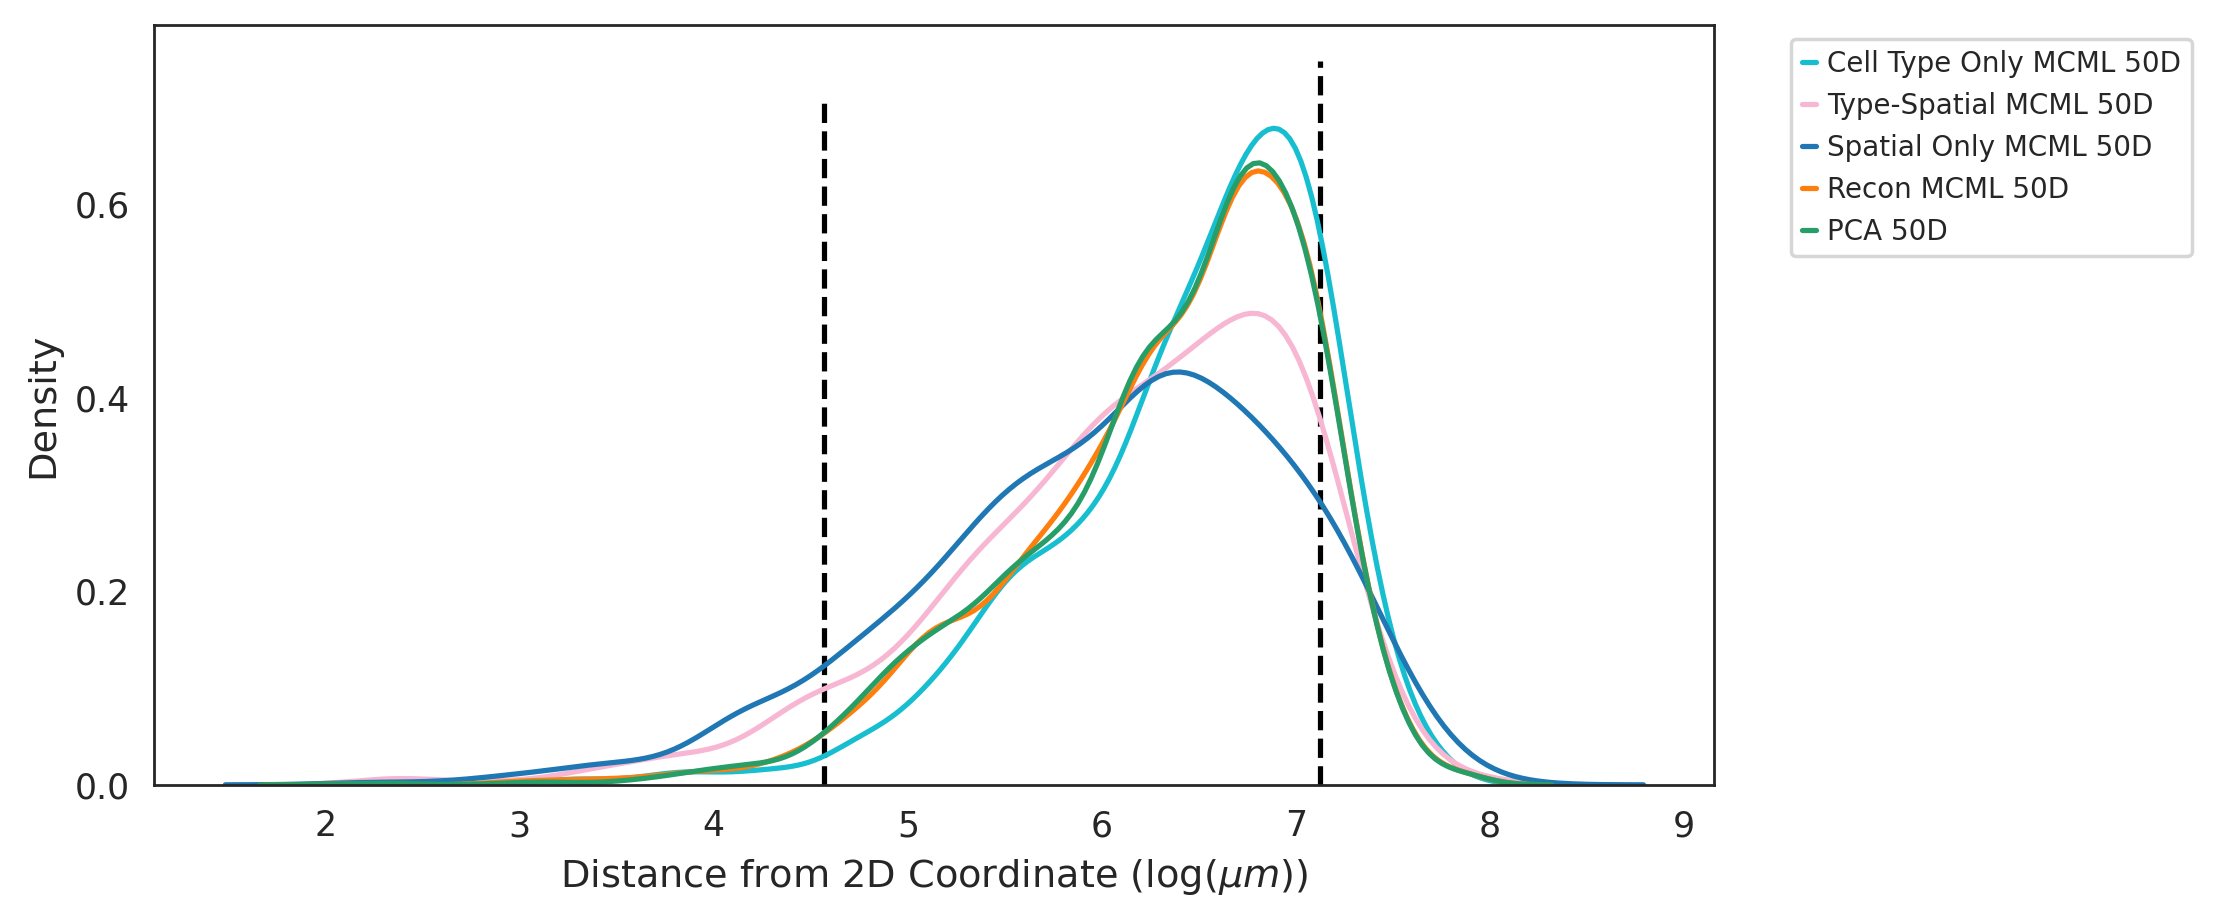

In [ ]:
palette={"NCA 20% Unlabeled MCML 50D":sns.color_palette()[0],"Recon MCML 50D":sns.color_palette()[1],
                  "PCA 50D":sns.color_palette()[2],"PCA 2D":sns.color_palette()[3],"Recon MCML TSNE":sns.color_palette()[4],"PCA t-SNE":sns.color_palette()[5],
                  "Recon MCML UMAP":sns.color_palette()[6],"PCA UMAP":sns.color_palette()[7],
                  "Type NCA 20% Unlabeled MCML 50D":sns.color_palette()[8],"Dual NCA 20% Unlabeled MCML 50D":sns.color_palette()[15]}


plt.figure(figsize=(8,4))
sns.kdeplot(knnDF.logx[knnDF.latent.isin(["Type NCA 20% Unlabeled MCML 50D"])],color=sns.color_palette()[8],label='Cell Type Only MCML 50D')
sns.kdeplot(knnDF.logx[knnDF.latent.isin(["Dual NCA 20% Unlabeled MCML 50D"])],color=sns.color_palette()[15],label='Type-Spatial MCML 50D')
sns.kdeplot(knnDF.logx[knnDF.latent.isin(["NCA 20% Unlabeled MCML 50D"])],color=sns.color_palette()[0],label='Spatial Only MCML 50D')
sns.kdeplot(knnDF.logx[knnDF.latent.isin(["Recon MCML 50D"])],color=sns.color_palette()[1],label='Recon MCML 50D')
g=sns.kdeplot(knnDF.logx[knnDF.latent.isin(["PCA 50D"])],color=sns.color_palette()[2],label='PCA 50D')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":8})

plt.vlines([np.log(avg)],g.get_ylim()[0],g.get_ylim()[1], linestyles='dashed', colors='black') #mean distances between cells (50 NNs)
plt.vlines([np.log(np.mean(allD[allD!=0]))],g.get_ylim()[0],g.get_ylim()[1], linestyles='dashed', colors='black') #mean distances between cells

plt.xlabel("Distance from 2D Coordinate (log"+r"($\mu m$))",fontsize=11)

plt.ylabel("Density",fontsize=11)


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

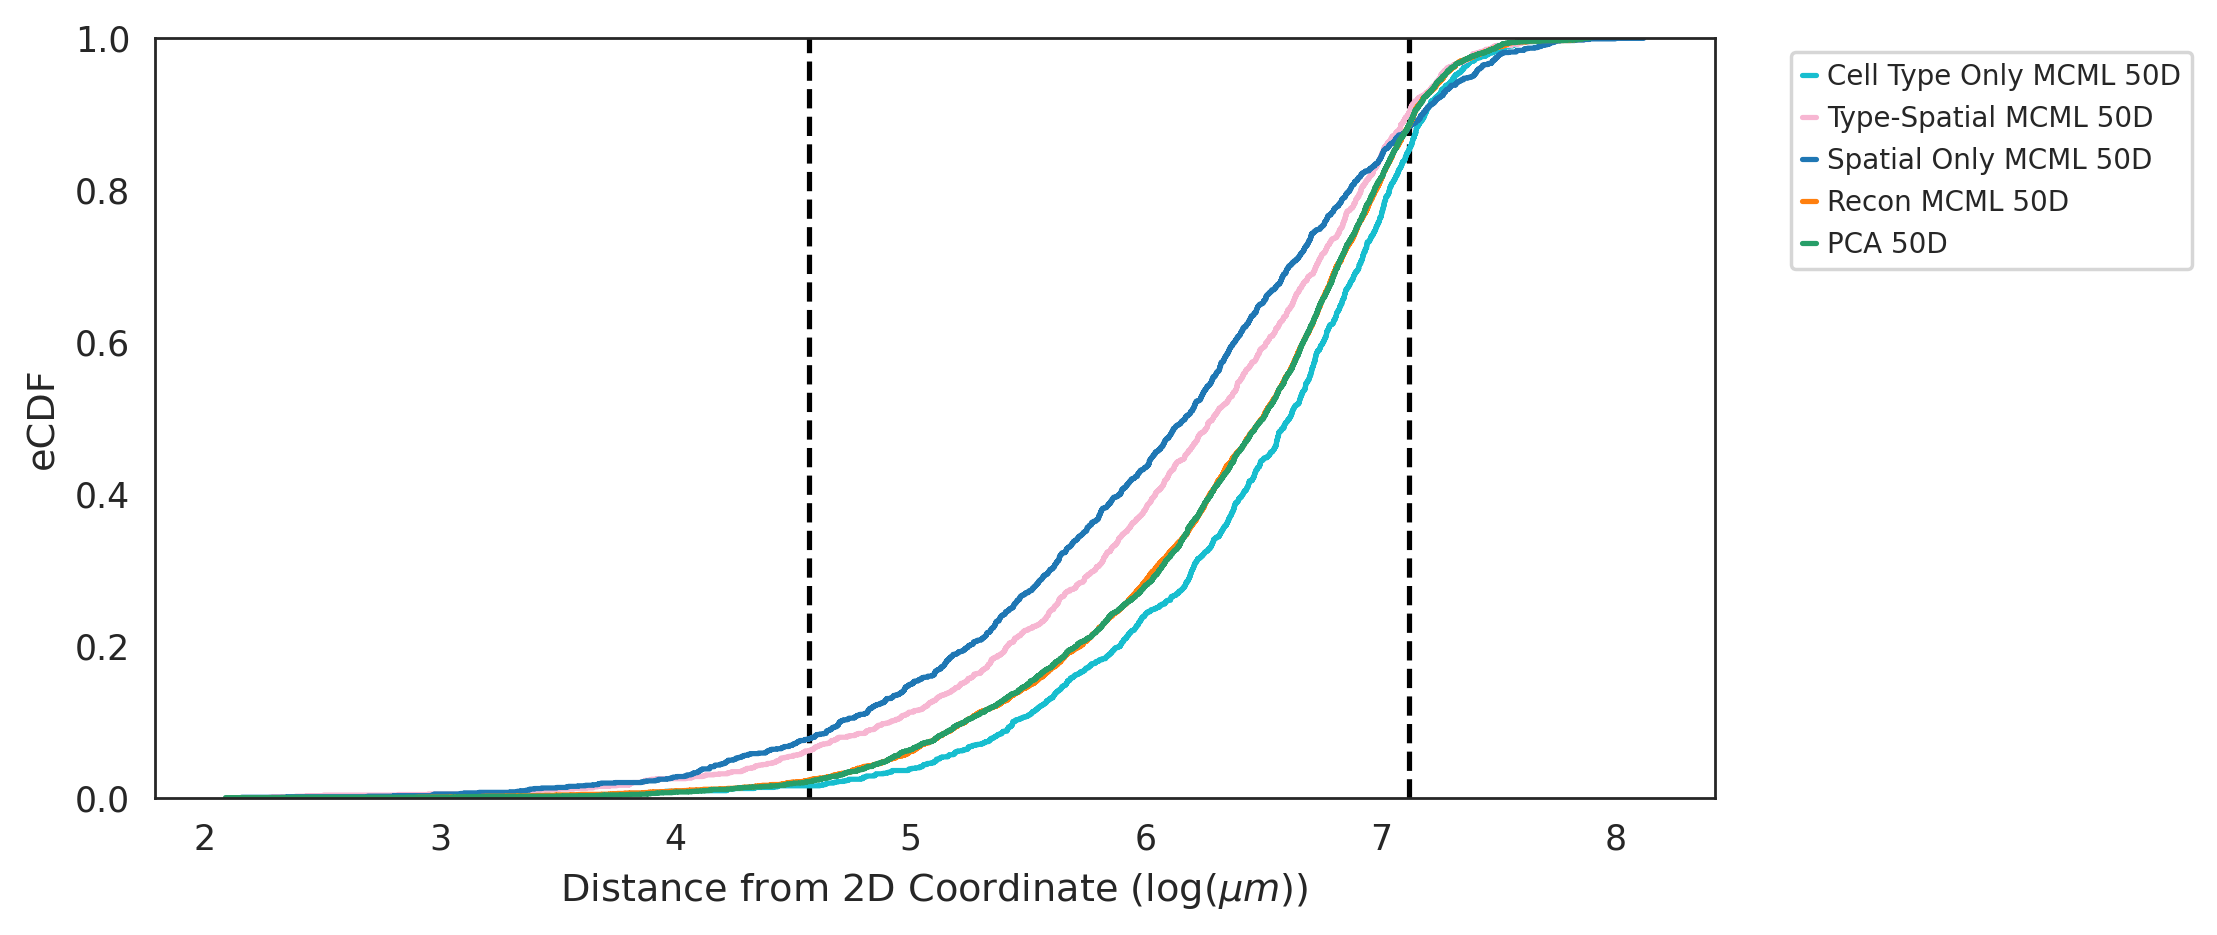

In [ ]:
palette={"NCA 20% Unlabeled MCML 50D":sns.color_palette()[0],"Recon MCML 50D":sns.color_palette()[1],
                  "PCA 50D":sns.color_palette()[2],"PCA 2D":sns.color_palette()[3],"Recon MCML TSNE":sns.color_palette()[4],"PCA TSNE":sns.color_palette()[5],
                  "Recon MCML UMAP":sns.color_palette()[6],"PCA UMAP":sns.color_palette()[7],
                  "Type NCA 20% Unlabeled MCML 50D":sns.color_palette()[8],"Dual NCA 20% Unlabeled MCML 50D":sns.color_palette()[15]}


plt.figure(figsize=(8,4))
sns.ecdfplot(knnDF.logx[knnDF.latent.isin(["Type NCA 20% Unlabeled MCML 50D"])],color=sns.color_palette()[8],label='Cell Type Only MCML 50D')
sns.ecdfplot(knnDF.logx[knnDF.latent.isin(["Dual NCA 20% Unlabeled MCML 50D"])],color=sns.color_palette()[15],label='Type-Spatial MCML 50D')
sns.ecdfplot(knnDF.logx[knnDF.latent.isin(["NCA 20% Unlabeled MCML 50D"])],color=sns.color_palette()[0],label='Spatial Only MCML 50D')
sns.ecdfplot(knnDF.logx[knnDF.latent.isin(["Recon MCML 50D"])],color=sns.color_palette()[1],label='Recon MCML 50D')
g=sns.ecdfplot(knnDF.logx[knnDF.latent.isin(["PCA 50D"])],color=sns.color_palette()[2],label='PCA 50D')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":8})

plt.vlines([np.log(avg)],g.get_ylim()[0],g.get_ylim()[1], linestyles='dashed', colors='black') #mean distances between cells
plt.vlines([np.log(np.mean(allD[allD!=0]))],g.get_ylim()[0],g.get_ylim()[1], linestyles='dashed', colors='black') #mean distances between cells

plt.xlabel("Distance from 2D Coordinate (log"+r"($\mu m$))",fontsize=11)

plt.ylabel("eCDF",fontsize=11)


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

### **Test Rare Cell Types**

Make matrix to test rare, orthogonal cell type reconstruction abilities

In [ ]:
num = 5 #2 no. of new cells
genes = 3 #2 no. of orthogonal genes expressed

newMat = np.zeros([orig_mat.shape[0]+num,orig_mat.shape[1]+genes])
newMat[0:orig_mat.shape[0],0:orig_mat.shape[1]] = orig_mat
#orig_mat.shape

In [ ]:
print(orig_mat.shape)
print(newMat.shape)

(6963, 254)
(6968, 257)


In [ ]:
newMat[orig_mat.shape[0]:orig_mat.shape[0]+num,orig_mat.shape[1]:orig_mat.shape[1]+genes] = 1

newMat

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.79152155, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

In [ ]:
#Mimick usual preprocessing steps
new_log_mat = np.log1p(newMat)

new_adata = anndata.AnnData(X=new_log_mat)

#Center scale
sc.pp.scale(new_adata, max_value=10)

new_scaled_mat = new_adata.X

In [ ]:
new_labs = np.array([list(sub.obs['type'])+['Rare']*num])

In [ ]:
#PCA 
tsvd = TruncatedSVD(n_components=pcs)
x_pca = tsvd.fit_transform(new_scaled_mat)

tsvd = TruncatedSVD(n_components=2)
x_pca_2d = tsvd.fit_transform(new_scaled_mat)



Run Recon MCML (Reconstruction error only)

In [ ]:
ncaR = MCML(n_latent = n_latent, epochs = 50) #n_latent

tic = time.perf_counter()
lossesR, latentR = ncaR.fit(new_scaled_mat,new_labs,fracNCA = 0, silent = True,ret_loss = True)
toc = time.perf_counter()
print(f"nnNCA fit in {toc - tic:0.4f} seconds")



nnNCA fit in 55.8944 seconds


In [ ]:
latents = [ x_pca, latentR] # [latentRare,  x_pca, latentR, x_pca_2d ]
latent = ['PCA 50D','Recon MCML 50D']  #['NCA 50D', 'PCA 50D','Recon 50D','PCA 2D' ]

Get Inter-distances for the newly added 'Rare' cell type

In [ ]:

#Sncg , Sst_Chodl , Vip
name = 'Rare'

allDists = []

dists = tl.getCentroidDists_oneVsAll(new_log_mat, new_labs[0],name) #Set ambient inter-type distances

emb = []
vals = []
dist = []

allVals = pd.DataFrame()


for p in range(len(latents)):

  i = latents[p]
  l = latent[p]

  # sub1 = i[labs[0]== name,:]
  # sub2 = i[labs[0] == name,:]

  ldists = tl.getCentroidDists_oneVsAll(i, new_labs[0],name)
  allDists += [ldists]
  #ldists = ldists.flatten().tolist()
  


  vals += [stats.pearsonr(ldists, dists)[0]]
  #stats.pearsonr(cond, ambCond)[0],stats.pearsonr(intraCond, ambIntraCond)[0]
  dist += ['Inter-type'] 


  emb += [l]

allVals['Latent'] = emb
allVals['Distance'] = dist
allVals['Pearsonr'] = vals
allVals['AllDistances'] = allDists


In [ ]:
allVals

Latent  ...                                       AllDistances
0         PCA 50D  ...  [45.20793657260947, 38.30386571340205, 51.4778...
1  Recon MCML 50D  ...  [35.18592576519586, 25.942367877811193, 49.777...

[2 rows x 4 columns]

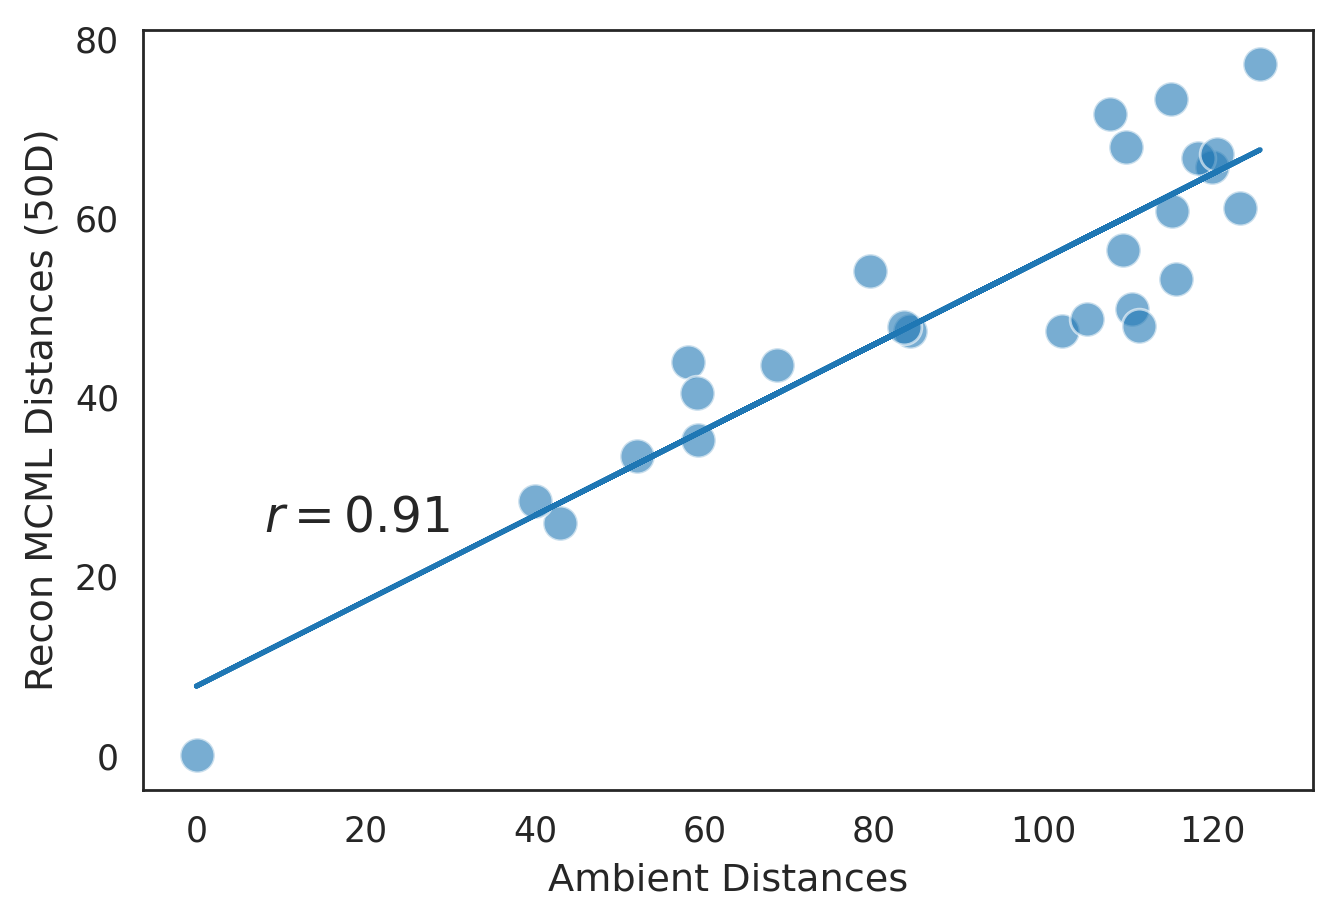

In [ ]:
plt.figure(figsize=(6,4))
x = dists
y = list(allVals['AllDistances'][allVals['Latent']=='Recon MCML 50D'])[0]
sns.scatterplot(x=x, y=y,s=100,alpha= 0.6)
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*np.array(x) + b)#linestyle='solid',alpha=0.6,color='black') 
plt.xlabel('Ambient Distances',fontsize = 11)
plt.ylabel('Recon MCML Distances (50D)',fontsize = 11)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.text(8, 25, r'$r = 0.91$', fontsize=14)
#plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.show()

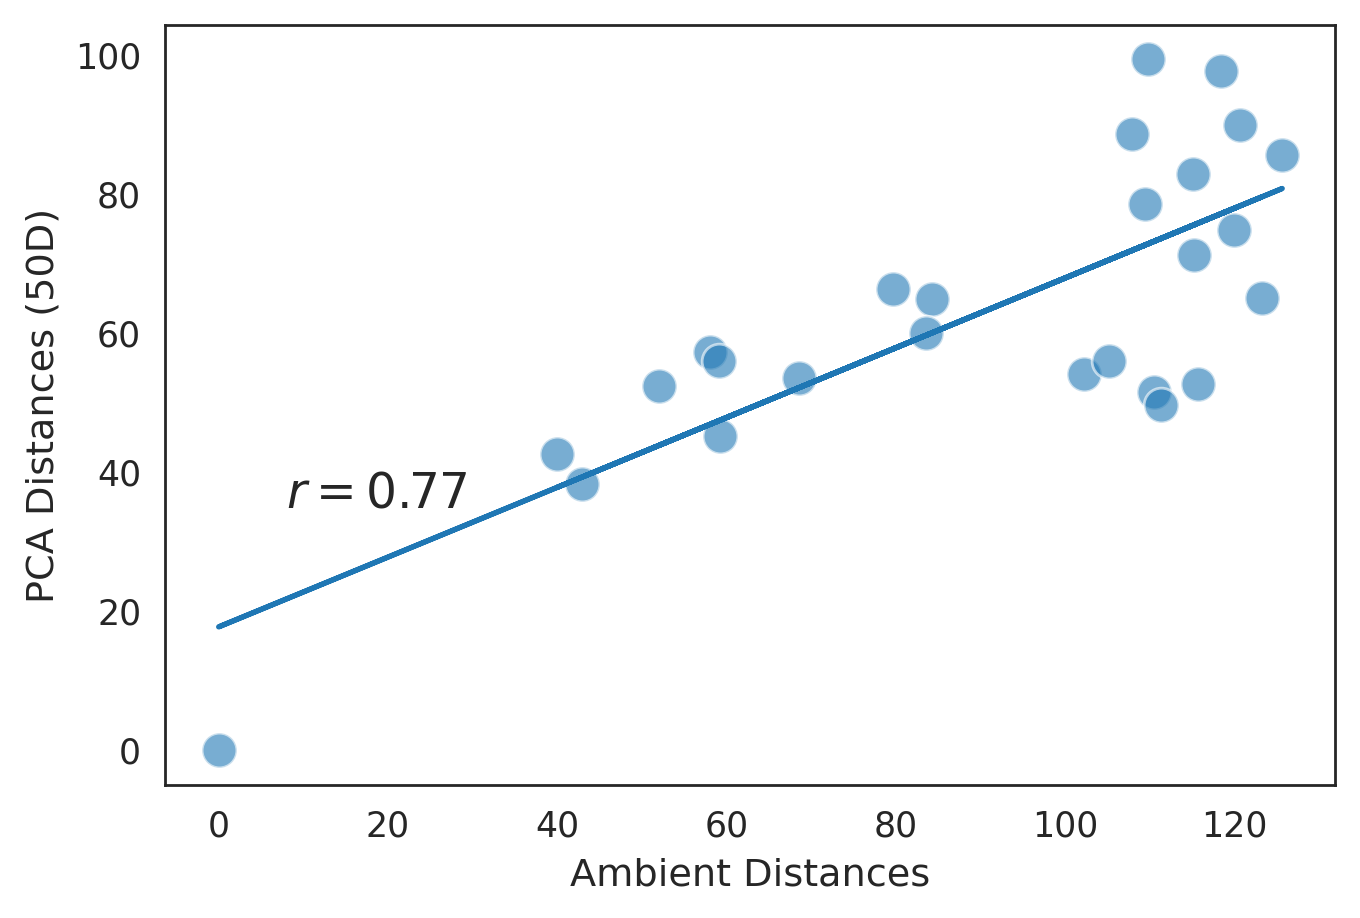

In [ ]:
y = list(allVals['AllDistances'][allVals['Latent']=='PCA 50D'])[0]
plt.figure(figsize=(6,4))
sns.scatterplot(x=x, y=y,s=100,alpha= 0.6) 
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*np.array(x) + b)
plt.xlabel('Ambient Distances',fontsize = 11)
plt.ylabel('PCA Distances (50D)',fontsize = 11)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.text(8, 35, r'$r = 0.77$', fontsize=14)
#plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.show()